# Phishing Detection Model Training with WandB

This notebook trains and evaluates three phishing detection models:
1. **TF-IDF + Logistic Regression** (baseline)
2. **Hybrid XGBoost** (text embeddings + engineered features)
3. **Hybrid MLP** (text embeddings + engineered features)

All experiments are tracked using Weights & Biases for reproducibility and comparison.

## 1. Install and Import Required Libraries

In [61]:
import os
import sys
import json
import pickle
from datetime import datetime
from pathlib import Path
import numpy as np
import polars as pl
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import wandb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
from sentence_transformers import SentenceTransformer
import xgboost as xgb
import optuna
from optuna.integration.wandb import WeightsAndBiasesCallback

import matplotlib.pyplot as plt
import seaborn as sns

# Add parent directory to path for imports
sys.path.append(str(Path.cwd().parent.parent))

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
print(f"Optuna version: {optuna.__version__}")

PyTorch version: 2.5.1+cu121
CUDA available: True
Device: cuda
Optuna version: 4.6.0


## 2. Configure WandB and Experiment Settings

In [62]:
wandb.login()

config = {
    "random_seed": 42,
    "train_split": 0.6,
    "test_split": 0.2,
    "external_split": 0.2,
    "data_source": "emails_v4.parquet",
    
    "numeric_features": [
        "sender_domain_entropy", "has_attachment",
        "spf_flag_missing", "dkim_flag_missing",
        "num_links", "subject_length", "body_length", "keyword_count", 
        "num_received_headers", "num_exclamation_marks", 
        "num_malicious_links"
    ],
    "embedding_model": "all-MiniLM-L6-v2",
    "embedding_dim": 384,
    
    # TF-IDF optimized params 
    "tfidf_max_features": 10000,
    "tfidf_ngram_range": (1, 1),
    "tfidf_min_df": 8,
    "tfidf_max_df": 0.95,
    "tfidf_threshold": 0.4,
    "lr_max_iter": 1000,
    "lr_C": 1.299304926078878,
    "lr_class_weight_ratio": 9.0,
    
    # XGBoost recall-optimized params 
    "xgb_max_depth": 8,
    "xgb_n_estimators": 350,
    "xgb_learning_rate": 0.02267537876243619,
    "xgb_min_child_weight": 5,
    "xgb_subsample": 0.95,
    "xgb_colsample_bytree": 0.85,
    "xgb_scale_pos_weight": 7.5,
    "xgb_threshold": 0.4,
    "xgb_early_stopping": 20,
    
    # MLP recall-optimized params
    "mlp_feature_hidden_dim": 64,
    "mlp_dropout": 0.5,
    "mlp_lr": 0.0028961603572682073,
    "mlp_weight_decay": 0.00011146976827416427,
    "mlp_epochs": 50,
    "mlp_batch_size": 128,
    "mlp_pos_weight": 8.5,
    "mlp_threshold": 0.4,
    "mlp_early_stopping": 10,
}
wandb.init(project="phishstop-hyperparameter-tuning", config=config)


## 3. Load and Prepare Dataset

In [63]:
# Load dataset
print("Loading dataset...")
df = pl.read_parquet("../../emails_v6.parquet")
pl.Config.set_tbl_rows(-1)
print(df.select("source").unique())
print(f"Total records: {len(df):,}")
print(f"Columns: {df.columns}")

# Check class distribution
phishing_count = df.filter(pl.col("phishing") == 1).shape[0]
legit_count = df.filter(pl.col("phishing") == 0).shape[0]

print(f"\nClass distribution:")
print(f"  Phishing: {phishing_count:,} ({phishing_count/len(df)*100:.2f}%)")
print(f"  Legitimate: {legit_count:,} ({legit_count/len(df)*100:.2f}%)")

# Log to WandB
wandb.log({
    "total_records": len(df),
    "phishing_count": phishing_count,
    "legit_count": legit_count,
    "class_balance": phishing_count / len(df)
})

Loading dataset...
shape: (22, 1)
┌────────────────────────────┐
│ source                     │
│ ---                        │
│ str                        │
╞════════════════════════════╡
│ phishing-2023              │
│ data/csv_misc/TREC-05.csv  │
│ data/csv_misc/TREC-07.csv  │
│ phishing-2021              │
│ phishing-2022              │
│ phishing-2015              │
│ phishing-2013              │
│ mbox_andrunik.mbox         │
│ data/csv_misc/CEAS-08.csv  │
│ data/csv_misc/Ling.csv     │
│ phishing-2024              │
│ phishing-2017              │
│ data/csv_misc/TREC-06.csv  │
│ phishing-2014              │
│ phishing-2020              │
│ phishing-2019              │
│ phishing-2018              │
│ data/csv_misc/Assassin.csv │
│ mbox_gradzki.mbox          │
│ data/csv_misc/Enron.csv    │
│ phishing-2016              │
│ phishing-nigerian          │
└────────────────────────────┘
Total records: 212,113
Columns: ['source', 'phishing', 'spf_flag', 'dkim_flag', 'd_flag', 'num_rec

## 3.1. Dataset Distribution Analysis

DATASET SOURCE DISTRIBUTION
shape: (22, 4)
┌────────────────────────────┬───────┬────────────────┬────────────────┐
│ source                     ┆ count ┆ phishing_count ┆ phishing_ratio │
│ ---                        ┆ ---   ┆ ---            ┆ ---            │
│ str                        ┆ u32   ┆ u32            ┆ f64            │
╞════════════════════════════╪═══════╪════════════════╪════════════════╡
│ data/csv_misc/TREC-07.csv  ┆ 53164 ┆ 28862          ┆ 0.542886       │
│ data/csv_misc/TREC-05.csv  ┆ 49843 ┆ 18443          ┆ 0.370022       │
│ data/csv_misc/CEAS-08.csv  ┆ 38736 ┆ 21456          ┆ 0.553903       │
│ data/csv_misc/Enron.csv    ┆ 28799 ┆ 13244          ┆ 0.459877       │
│ data/csv_misc/TREC-06.csv  ┆ 15712 ┆ 3582           ┆ 0.227979       │
│ mbox_gradzki.mbox          ┆ 6373  ┆ 0              ┆ 0.0            │
│ data/csv_misc/Assassin.csv ┆ 5578  ┆ 1572           ┆ 0.281821       │
│ phishing-nigerian          ┆ 3901  ┆ 3901           ┆ 1.0            │
│ mbox_a

C:\Users\Latandu\AppData\Local\Temp\ipykernel_8824\4289937131.py:9: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("count"),


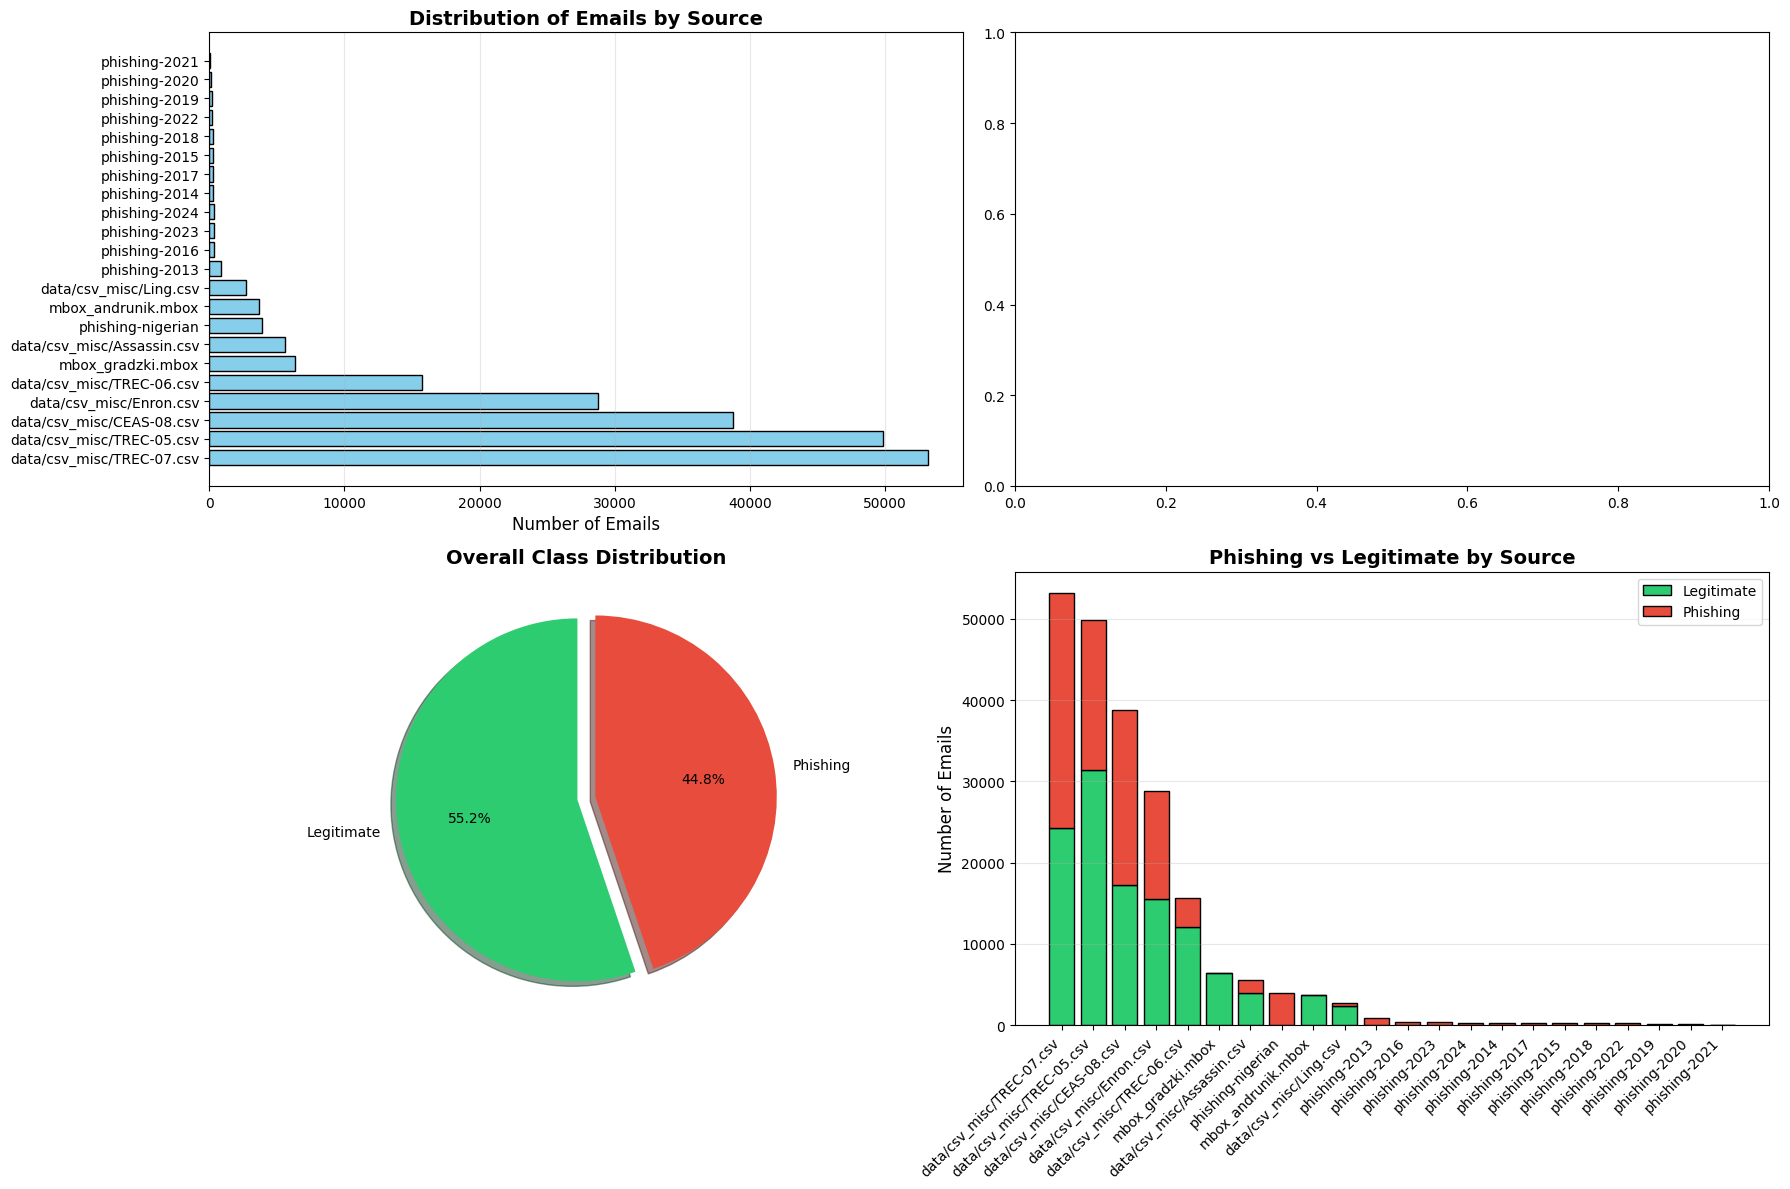

In [64]:
# Dataset source distribution
df_pd = df.to_pandas()

# 1. Source Distribution
print("="*80)
print("DATASET SOURCE DISTRIBUTION")
print("="*80)
source_counts = df.group_by("source").agg([
    pl.count().alias("count"),
    pl.col("phishing").sum().alias("phishing_count"),
    pl.col("phishing").mean().alias("phishing_ratio")
]).sort("count", descending=True)

print(source_counts)

# Plot source distribution
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Source count
ax1 = axes[0, 0]
source_data = source_counts.to_pandas()
ax1.barh(source_data['source'], source_data['count'], color='skyblue', edgecolor='black')
ax1.set_xlabel('Number of Emails', fontsize=12)
ax1.set_title('Distribution of Emails by Source', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Overall class distribution (pie chart)
ax3 = axes[1, 0]
class_counts = [legit_count, phishing_count]
colors_pie = ['#2ecc71', '#e74c3c']
explode = (0.05, 0.05)
ax3.pie(class_counts, labels=['Legitimate', 'Phishing'], autopct='%1.1f%%', 
        colors=colors_pie, explode=explode, shadow=True, startangle=90)
ax3.set_title('Overall Class Distribution', fontsize=14, fontweight='bold')

# Stacked bar chart - phishing vs legitimate by source
ax4 = axes[1, 1]
source_data['legitimate_count'] = source_data['count'] - source_data['phishing_count']
x_pos = np.arange(len(source_data))
ax4.bar(x_pos, source_data['legitimate_count'], label='Legitimate', color='#2ecc71', edgecolor='black')
ax4.bar(x_pos, source_data['phishing_count'], bottom=source_data['legitimate_count'], 
        label='Phishing', color='#e74c3c', edgecolor='black')
ax4.set_ylabel('Number of Emails', fontsize=12)
ax4.set_title('Phishing vs Legitimate by Source', fontsize=14, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(source_data['source'], rotation=45, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
wandb.log({"dataset_analysis/source_distribution": wandb.Image(fig)})
plt.show()
plt.close()

# Log source distribution table
wandb.log({"dataset_analysis/source_table": wandb.Table(
    columns=["source", "count", "phishing_count", "legitimate_count", "phishing_ratio"],
    data=source_data[['source', 'count', 'phishing_count', 'legitimate_count', 'phishing_ratio']].values.tolist()
)})


DATASET FORMAT ANALYSIS

Format Statistics:
format  total_count  phishing_count  phishing_ratio  legitimate_count  phishing_pct
   CSV       194579           87604        0.450223            106975     45.022330
  MBOX        17534            7459        0.425402             10075     42.540208


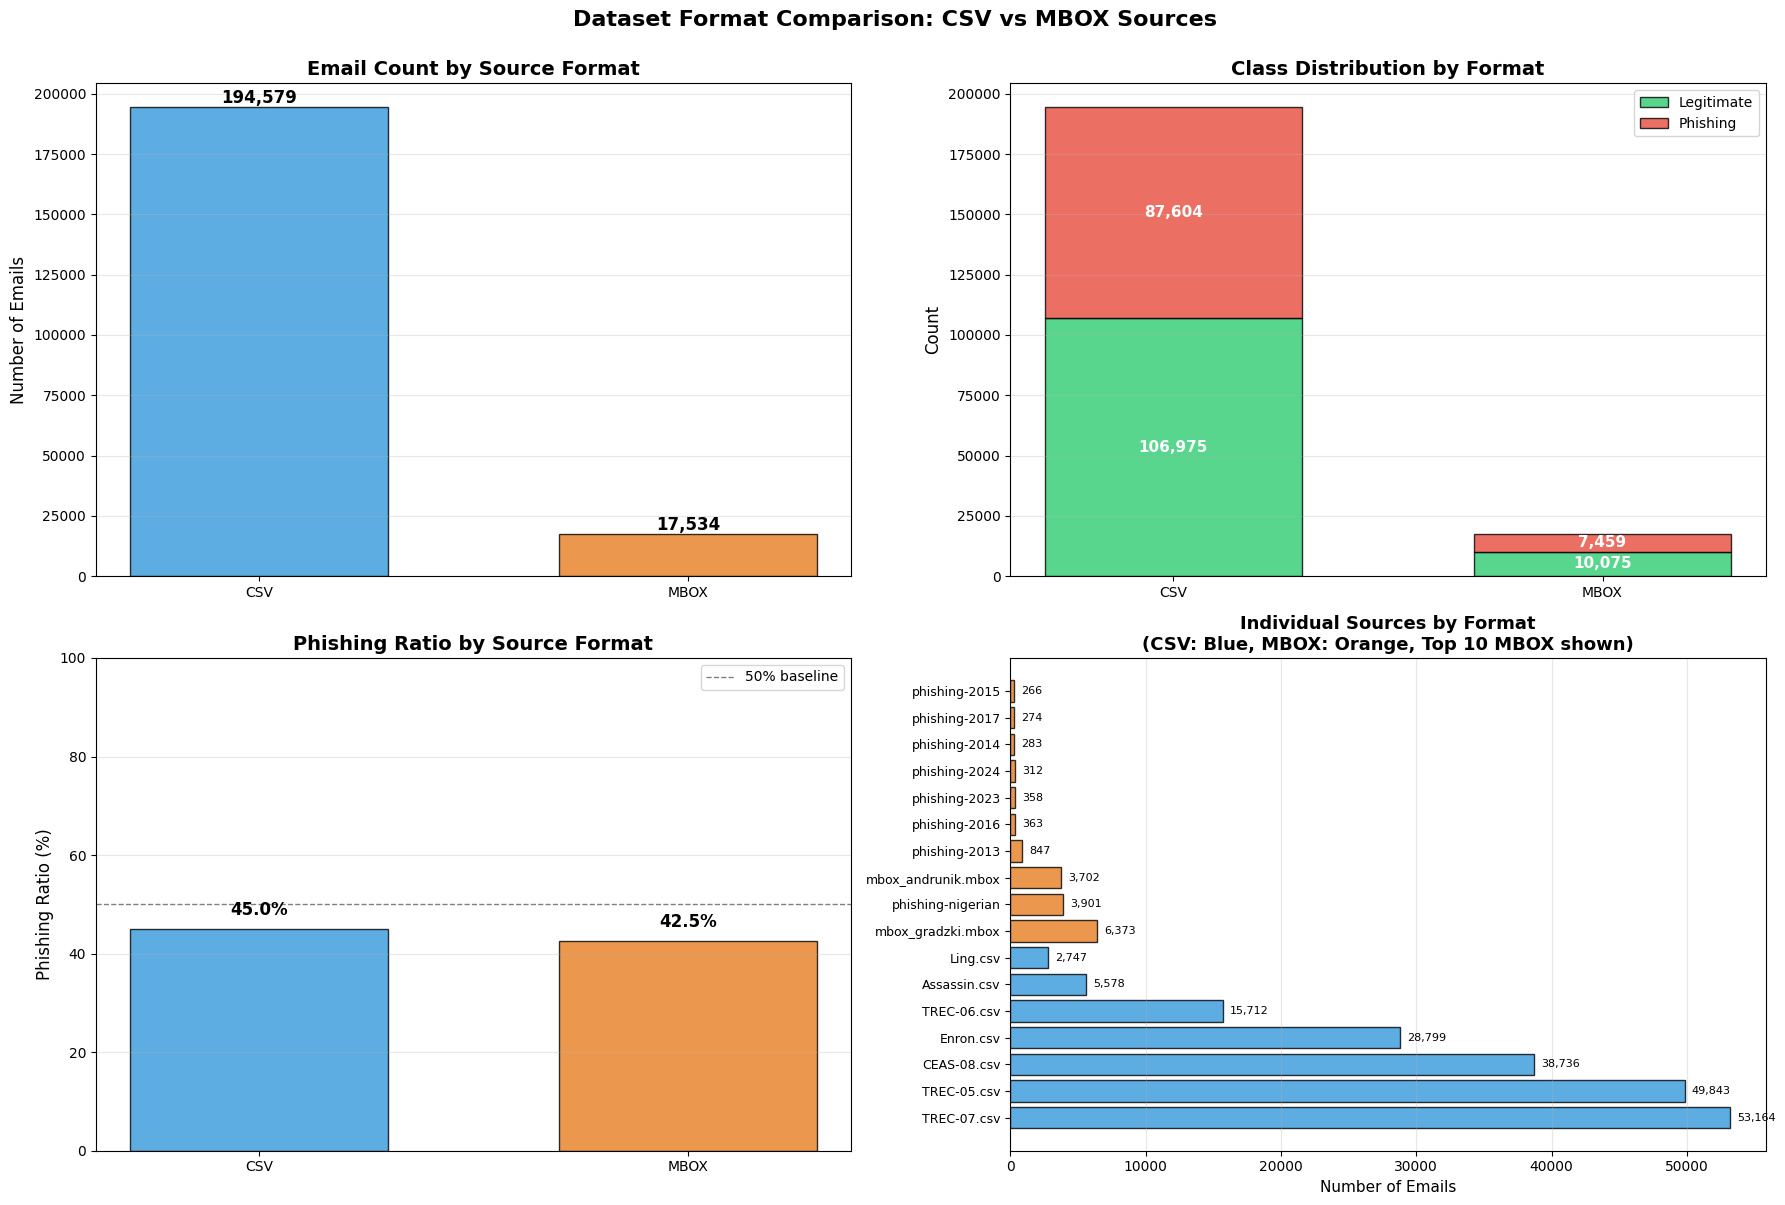


Format Breakdown:
  CSV sources:  194,579 emails (45.0% phishing)
  MBOX sources: 17,534 emails (42.5% phishing)


In [65]:
# -------------------------------------------------------------------------
# Dataset Format Analysis (CSV vs MBOX)
# -------------------------------------------------------------------------
print("\n" + "=" * 80)
print("DATASET FORMAT ANALYSIS")
print("=" * 80)

# Classify sources by format
df_pd['format'] = df_pd['source'].apply(lambda x: 'CSV' if 'csv_misc' in x else 'MBOX')

# Calculate statistics by format
format_stats = df_pd.groupby('format').agg({
    'phishing': ['count', 'sum', 'mean']
}).reset_index()

format_stats.columns = ['format', 'total_count', 'phishing_count', 'phishing_ratio']
format_stats['legitimate_count'] = format_stats['total_count'] - format_stats['phishing_count']
format_stats['phishing_pct'] = format_stats['phishing_ratio'] * 100

print("\nFormat Statistics:")
print(format_stats.to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Count by format
ax1 = axes[0, 0]
formats = format_stats['format'].values
counts = format_stats['total_count'].values
colors_format = ['#3498db', '#e67e22']

bars = ax1.bar(formats, counts, color=colors_format, edgecolor='black', alpha=0.8, width=0.6)
ax1.set_ylabel('Number of Emails', fontsize=12)
ax1.set_title('Email Count by Source Format', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add count labels
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(count):,}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# 2. Stacked bar - class distribution by format
ax2 = axes[0, 1]
x_pos = np.arange(len(formats))
width = 0.6

legit_counts_fmt = format_stats['legitimate_count'].values
phish_counts_fmt = format_stats['phishing_count'].values

bars1 = ax2.bar(x_pos, legit_counts_fmt, width, label='Legitimate',
               color='#2ecc71', edgecolor='black', alpha=0.8)
bars2 = ax2.bar(x_pos, phish_counts_fmt, width, bottom=legit_counts_fmt,
               label='Phishing', color='#e74c3c', edgecolor='black', alpha=0.8)

ax2.set_xticks(x_pos)
ax2.set_xticklabels(formats)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Class Distribution by Format', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add labels
for i, (bar1, bar2, legit, phish) in enumerate(zip(bars1, bars2, legit_counts_fmt, phish_counts_fmt)):
    # Legitimate label
    ax2.text(bar1.get_x() + bar1.get_width()/2., legit/2,
            f'{int(legit):,}',
            ha='center', va='center', fontsize=11, fontweight='bold', color='white')
    # Phishing label
    ax2.text(bar2.get_x() + bar2.get_width()/2., legit + phish/2,
            f'{int(phish):,}',
            ha='center', va='center', fontsize=11, fontweight='bold', color='white')

# 3. Phishing ratio comparison
ax3 = axes[1, 0]
phish_pcts = format_stats['phishing_pct'].values
bars = ax3.bar(formats, phish_pcts, color=colors_format, edgecolor='black', alpha=0.8, width=0.6)
ax3.set_ylabel('Phishing Ratio (%)', fontsize=12)
ax3.set_title('Phishing Ratio by Source Format', fontsize=14, fontweight='bold')
ax3.axhline(y=50, color='black', linestyle='--', linewidth=1, alpha=0.5, label='50% baseline')
ax3.set_ylim([0, 100])
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Add percentage labels
for bar, pct in zip(bars, phish_pcts):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{pct:.1f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# 4. Source breakdown within each format
ax4 = axes[1, 1]

# Get top sources for each format
csv_sources = df_pd[df_pd['format'] == 'CSV']['source'].value_counts()
mbox_sources = df_pd[df_pd['format'] == 'MBOX']['source'].value_counts()

# Plot CSV sources
y_pos = 0
colors_bar = []
labels = []
values = []

for source, count in csv_sources.items():
    labels.append(source.split('/')[-1])
    values.append(count)
    colors_bar.append('#3498db')
    y_pos += 1

# Add separator
y_pos += 0.5

# Plot MBOX sources (top 10)
for source, count in mbox_sources.head(10).items():
    labels.append(source.split('/')[-1] if '/' in source else source)
    values.append(count)
    colors_bar.append('#e67e22')
    y_pos += 1

y_positions = np.arange(len(labels))
ax4.barh(y_positions, values, color=colors_bar, edgecolor='black', alpha=0.8)
ax4.set_yticks(y_positions)
ax4.set_yticklabels(labels, fontsize=9)
ax4.set_xlabel('Number of Emails', fontsize=11)
ax4.set_title('Individual Sources by Format\n(CSV: Blue, MBOX: Orange, Top 10 MBOX shown)',
              fontsize=13, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# Add count labels
for y, val in zip(y_positions, values):
    ax4.text(val + max(values)*0.01, y, f'{int(val):,}',
            ha='left', va='center', fontsize=8)

plt.suptitle('Dataset Format Comparison: CSV vs MBOX Sources',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
wandb.log({"dataset_analysis/format_comparison": wandb.Image(fig)})
plt.show()
plt.close()

# Log format statistics
print(f"\nFormat Breakdown:")
print(f"  CSV sources:  {format_stats[format_stats['format']=='CSV']['total_count'].values[0]:,} emails "
      f"({format_stats[format_stats['format']=='CSV']['phishing_pct'].values[0]:.1f}% phishing)")
print(f"  MBOX sources: {format_stats[format_stats['format']=='MBOX']['total_count'].values[0]:,} emails "
      f"({format_stats[format_stats['format']=='MBOX']['phishing_pct'].values[0]:.1f}% phishing)")

wandb.log({"dataset_analysis/format_stats": wandb.Table(dataframe=format_stats)})


=== Text Length Statistics ===

Legitimate Emails:
  Total Length (body + subject): mean=2139.2, median=1063.0, std=11333.4
  Subject Length: mean=38.1, median=34.0
  Body Length: mean=2099.1, median=1023.0

Phishing Emails:
  Total Length (body + subject): mean=1201.2, median=626.0, std=3013.2
  Subject Length: mean=34.4, median=30.0
  Body Length: mean=1164.8, median=591.0


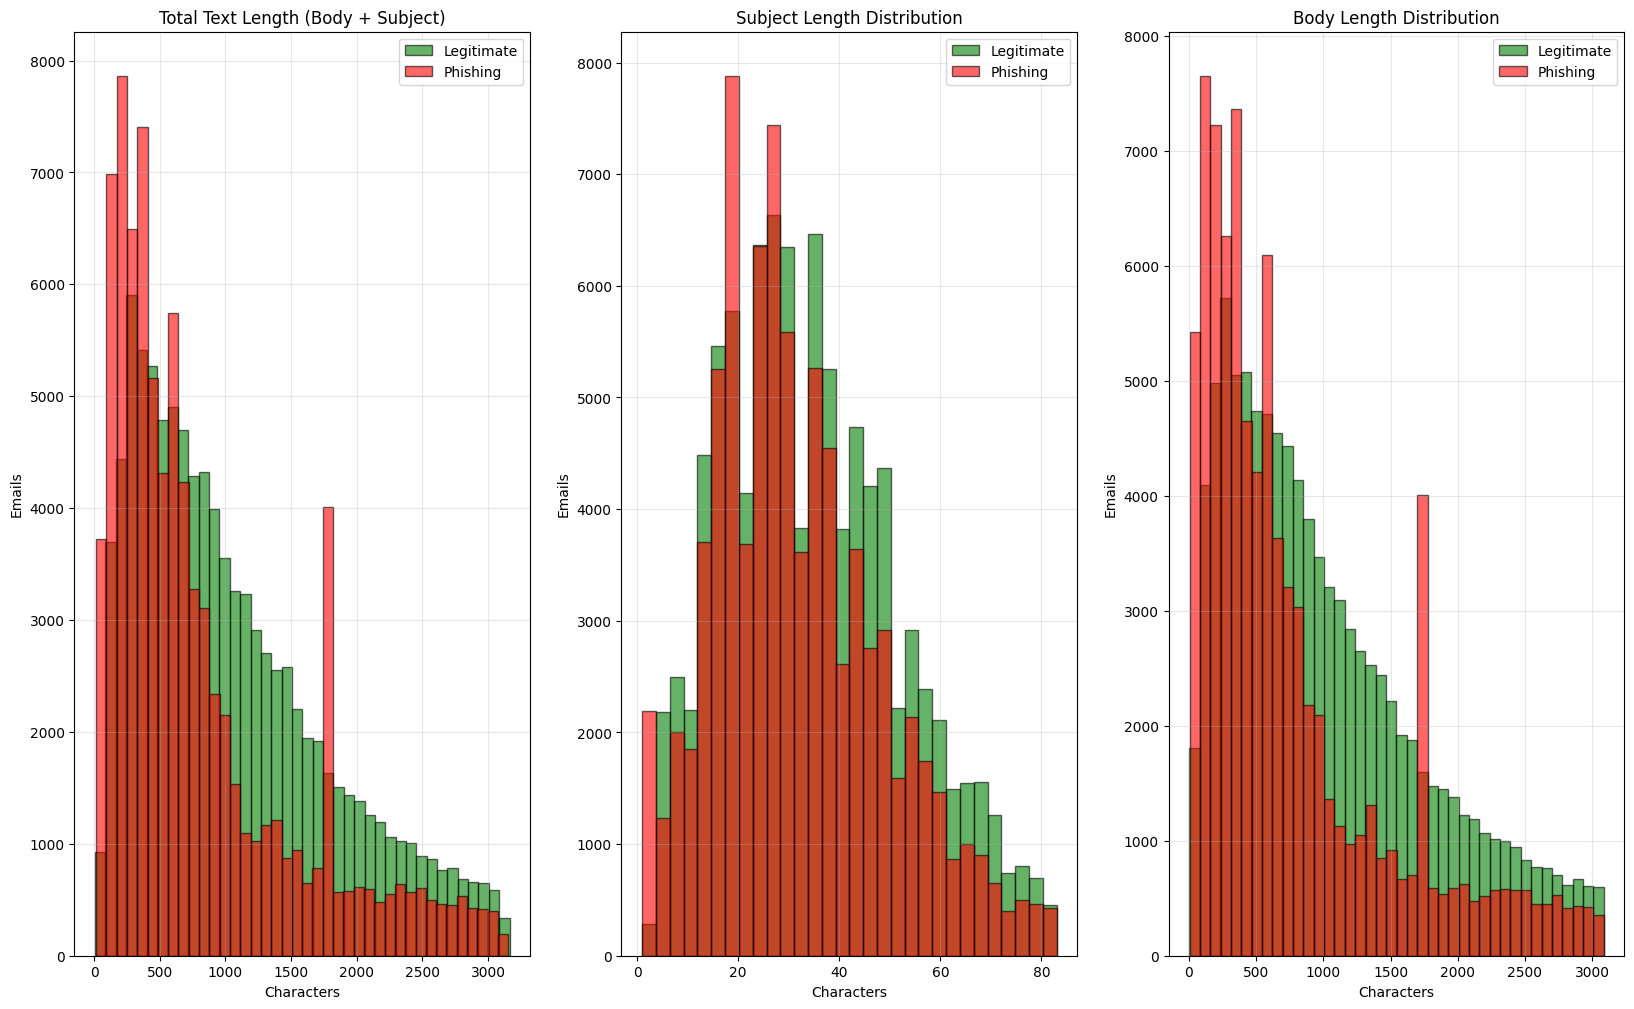

In [66]:
df_pd["body_subject_length"] = df_pd["body_subject"].str.len()
df_pd["subject_length_actual"] = df_pd["subject"].str.len()
df_pd["body_length_actual"] = df_pd["body_text"].str.len()


print("\n=== Text Length Statistics ===")
for label, name in [(0, "Legitimate"), (1, "Phishing")]:
    subset = df_pd[df_pd["phishing"] == label]

    print(f"\n{name} Emails:")
    print(f"  Total Length (body + subject): "
          f"mean={subset['body_subject_length'].mean():.1f}, "
          f"median={subset['body_subject_length'].median():.1f}, "
          f"std={subset['body_subject_length'].std():.1f}")

    print(f"  Subject Length: mean={subset['subject_length_actual'].mean():.1f}, "
          f"median={subset['subject_length_actual'].median():.1f}")

    print(f"  Body Length: mean={subset['body_length_actual'].mean():.1f}, "
          f"median={subset['body_length_actual'].median():.1f}")

def remove_iqr_outliers_df(df, columns):
    """Remove outliers from dataframe using IQR method"""
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean


# Create filtered dataframe for visualization
length_cols = ["body_subject_length", "subject_length_actual", "body_length_actual"]
df_vis = remove_iqr_outliers_df(df_pd, length_cols)

LEGIT = df_vis[df_vis["phishing"] == 0]
PHISH = df_vis[df_vis["phishing"] == 1]

# -------------------------------------------------------------------------
# Plot Distributions
# -------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 12))
axes = axes.flatten()

# ---------------------- 1. Total Length -------------------------
ax = axes[0]
ax.hist(LEGIT["body_subject_length"], bins=40, alpha=0.6,
        label="Legitimate", color="green", edgecolor="black")
ax.hist(PHISH["body_subject_length"], bins=40, alpha=0.6,
        label="Phishing", color="red", edgecolor="black")
ax.set_title("Total Text Length (Body + Subject)")
ax.set_xlabel("Characters")
ax.set_ylabel("Emails")
ax.grid(alpha=0.3)
ax.legend()

# ---------------------- 2. Subject Length -------------------------
ax = axes[1]
ax.hist(LEGIT["subject_length_actual"], bins=30, alpha=0.6,
        label="Legitimate", color="green", edgecolor="black")
ax.hist(PHISH["subject_length_actual"], bins=30, alpha=0.6,
        label="Phishing", color="red", edgecolor="black")
ax.set_title("Subject Length Distribution")
ax.set_xlabel("Characters")
ax.set_ylabel("Emails")
ax.grid(alpha=0.3)
ax.legend()

# ---------------------- 3. Body Length -------------------------
ax = axes[2]
ax.hist(LEGIT["body_length_actual"], bins=40, alpha=0.6,
        label="Legitimate", color="green", edgecolor="black")
ax.hist(PHISH["body_length_actual"], bins=40, alpha=0.6,
        label="Phishing", color="red", edgecolor="black")
ax.set_title("Body Length Distribution")
ax.set_xlabel("Characters")
ax.set_ylabel("Emails")
ax.grid(alpha=0.3)
ax.legend()

stats_table = []
for label, name in [(0, "Legitimate"), (1, "Phishing")]:
    subset = df_pd[df_pd["phishing"] == label]
    stats_table.append([
        name,
        subset["body_subject_length"].mean(),
        subset["body_subject_length"].median(),
        subset["body_subject_length"].std(),
        subset["subject_length_actual"].mean(),
        subset["body_length_actual"].mean(),
    ])

wandb.log({
    "dataset_analysis/text_length_stats": wandb.Table(
        columns=[
            "class",
            "avg_total_length",
            "median_total_length",
            "std_total_length",
            "avg_subject_length",
            "avg_body_length",
        ],
        data=stats_table
    )
})



Features dataframe shape: (212113, 12)
Columns: ['sender_domain_entropy', 'has_attachment', 'spf_flag_missing', 'dkim_flag_missing', 'num_links', 'subject_length', 'body_length', 'keyword_count', 'num_received_headers', 'num_exclamation_marks', 'num_malicious_links', 'phishing']

NUMERIC FEATURES DISTRIBUTION ANALYSIS (OUTLIERS REMOVED)
Outlier removal for num_links: removed 23684 rows
Outlier removal for keyword_count: removed 17124 rows
Outlier removal for num_received_headers: removed 3779 rows
Outlier removal for num_exclamation_marks: removed 20810 rows
Outlier removal for num_malicious_links: removed 1 rows
Outlier removal for sender_domain_entropy: removed 27248 rows

num_links:
  Legitimate: mean=30.076, median=2.000, std=41.548
  Phishing:   mean=24.336, median=23.000, std=29.284
  Difference: 5.739 (-19.1%)

keyword_count:
  Legitimate: mean=2.596, median=2.000, std=2.555
  Phishing:   mean=1.541, median=0.000, std=2.613
  Difference: 1.055 (-40.6%)

num_received_headers:
  

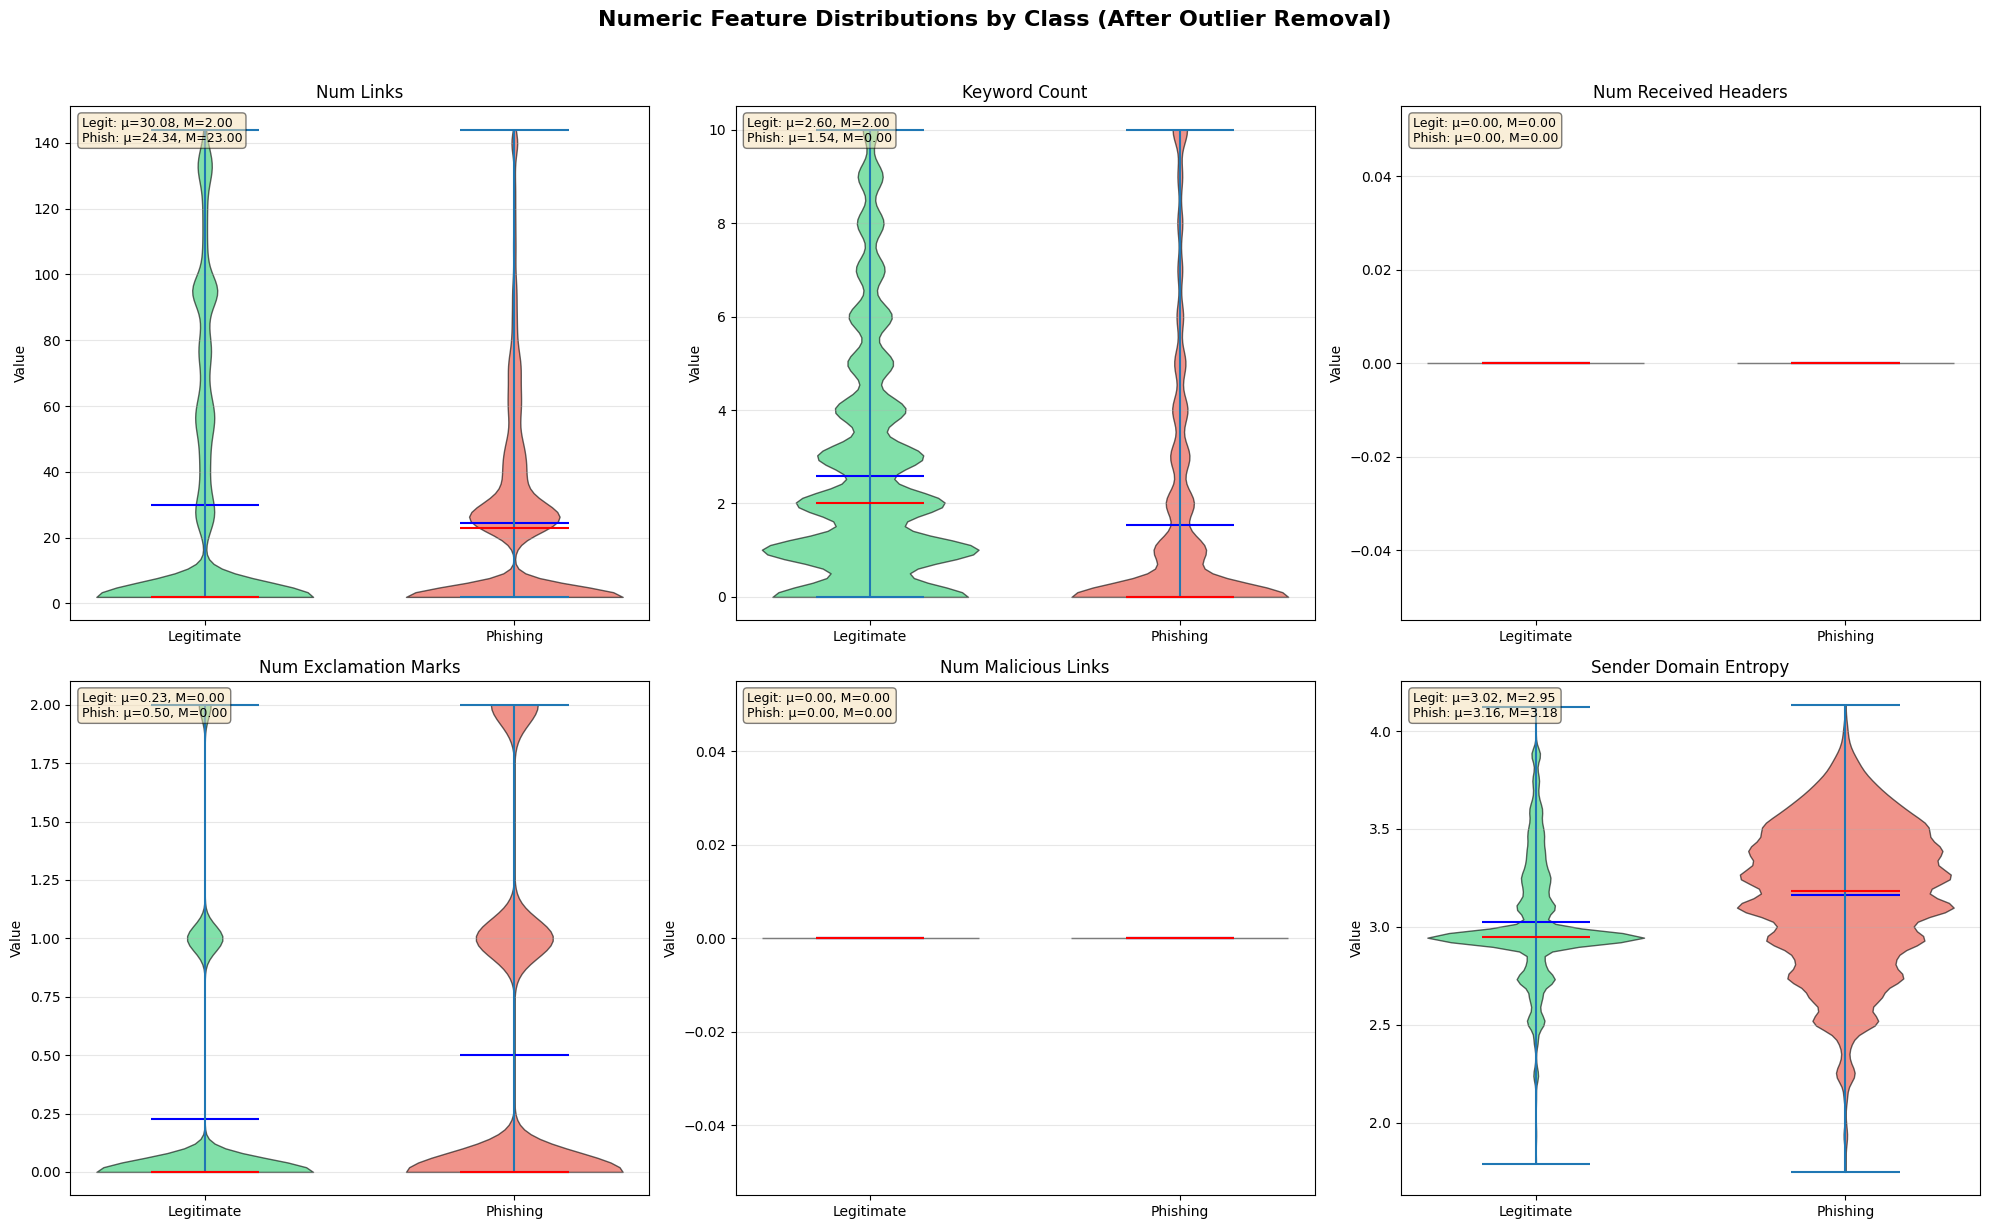

In [67]:
numeric_features_analysis = [
    "sender_domain_entropy", "has_attachment",
    "spf_flag_missing", "dkim_flag_missing",
    "num_links", "subject_length", "body_length", "keyword_count", 
    "num_received_headers", "num_exclamation_marks", 
    "num_malicious_links"
]

features_analysis_df = df.select(numeric_features_analysis + ["phishing"]).to_pandas()

print(f"\nFeatures dataframe shape: {features_analysis_df.shape}")
print(f"Columns: {list(features_analysis_df.columns)}")

print("\n" + "=" * 80)
print("NUMERIC FEATURES DISTRIBUTION ANALYSIS (OUTLIERS REMOVED)")
print("=" * 80)

continuous_features = [
    "num_links",
   "keyword_count",
    "num_received_headers",
    "num_exclamation_marks",
    "num_malicious_links",
    "sender_domain_entropy",
]

def remove_outliers_iqr(df, columns):
    cleaned_df = df.copy()
    for col in columns:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        before = cleaned_df.shape[0]
        cleaned_df = cleaned_df[
            (cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)
        ]
        after = cleaned_df.shape[0]

        print(f"Outlier removal for {col}: removed {before - after} rows")

    return cleaned_df


features_analysis_df = remove_outliers_iqr(features_analysis_df, continuous_features)


fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, feature in enumerate(continuous_features):
    ax = axes[idx]

    legit_vals = features_analysis_df[features_analysis_df["phishing"] == 0][feature]
    phish_vals = features_analysis_df[features_analysis_df["phishing"] == 1][feature]

    # Violin plot makes differences between classes easier to see
    parts = ax.violinplot(
        [legit_vals, phish_vals],
        positions=[0, 1],
        showmeans=True,
        showmedians=True,
        widths=0.7
    )

    # Color the violins
    for body, color in zip(parts["bodies"], ["#2ecc71", "#e74c3c"]):
        body.set_facecolor(color)
        body.set_alpha(0.6)
        body.set_edgecolor("black")

    parts["cmeans"].set_color("blue")
    parts["cmedians"].set_color("red")

    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Legitimate", "Phishing"])
    ax.set_ylabel("Value")
    ax.set_title(feature.replace("_", " ").title())
    ax.grid(axis="y", alpha=0.3)

    # Summary statistics printed on the plot
    legit_mean, legit_median = legit_vals.mean(), legit_vals.median()
    phish_mean, phish_median = phish_vals.mean(), phish_vals.median()

    stats_text = (
        f"Legit: μ={legit_mean:.2f}, M={legit_median:.2f}\n"
        f"Phish: μ={phish_mean:.2f}, M={phish_median:.2f}"
    )

    ax.text(
        0.02, 0.98, stats_text,
        transform=ax.transAxes,
        fontsize=9,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5)
    )

    # Print stats to console as well
    print(f"\n{feature}:")
    print(f"  Legitimate: mean={legit_mean:.3f}, median={legit_median:.3f}, std={legit_vals.std():.3f}")
    print(f"  Phishing:   mean={phish_mean:.3f}, median={phish_median:.3f}, std={phish_vals.std():.3f}")
    diff = phish_mean - legit_mean
    pct = (diff / legit_mean * 100) if legit_mean != 0 else 0
    print(f"  Difference: {abs(diff):.3f} ({pct:.1f}%)")

plt.suptitle("Numeric Feature Distributions by Class (After Outlier Removal)", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()

wandb.log({"dataset_analysis/numeric_features_distribution": wandb.Image(fig)})
plt.show()
plt.close()


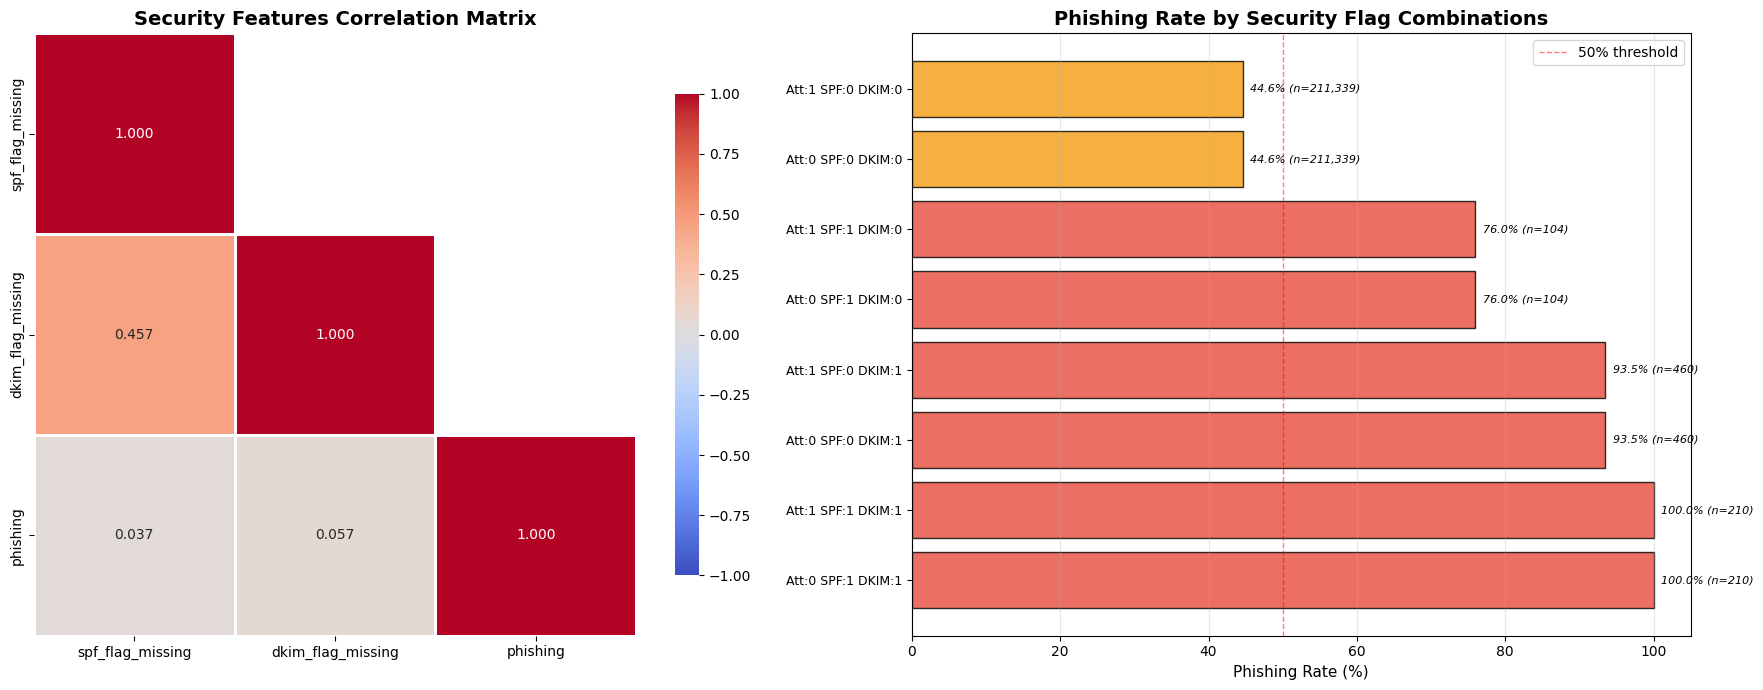


Key Insights:
  Highest risk combination: Att:0 SPF:1 DKIM:1 (100.0% phishing rate)
  Lowest risk combination: Att:1 SPF:0 DKIM:0 (44.6% phishing rate)


In [68]:
# Create contingency tables and calculate correlations
security_features = [ 'spf_flag_missing', 'dkim_flag_missing', 'phishing']
security_df = df_pd[security_features].copy()

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 1. Correlation heatmap
ax1 = axes[0]
corr_matrix = security_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, linewidths=2, cbar_kws={"shrink": 0.8},
            ax=ax1, vmin=-1, vmax=1)
ax1.set_title('Security Features Correlation Matrix', fontsize=14, fontweight='bold')

# 2. Combined security risk analysis
ax2 = axes[1]

# Count combinations
risk_combinations = []
risk_labels = []

for has_att in [0, 1]:
    for spf_miss in [0, 1]:
        for dkim_miss in [0, 1]:
            mask = (
                   (df_pd['spf_flag_missing'] == spf_miss) & 
                   (df_pd['dkim_flag_missing'] == dkim_miss))
            
            total = mask.sum()
            phishing = (mask & (df_pd['phishing'] == 1)).sum()
            phishing_rate = (phishing / total * 100) if total > 0 else 0
            
            if total >= 10:  # Only include combinations with sufficient samples
                label = f"Att:{has_att} SPF:{spf_miss} DKIM:{dkim_miss}"
                risk_combinations.append({
                    'label': label,
                    'total': total,
                    'phishing_rate': phishing_rate,
                    'spf_missing': spf_miss,
                    'dkim_missing': dkim_miss
                })

# Sort by phishing rate
risk_combinations.sort(key=lambda x: x['phishing_rate'], reverse=True)

# Plot
y_pos = np.arange(len(risk_combinations))
rates = [r['phishing_rate'] for r in risk_combinations]
labels = [r['label'] for r in risk_combinations]
totals = [r['total'] for r in risk_combinations]

# Color bars by risk level
colors = ['#e74c3c' if rate > 50 else '#f39c12' if rate > 25 else '#2ecc71' 
          for rate in rates]

bars = ax2.barh(y_pos, rates, color=colors, edgecolor='black', alpha=0.8)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels, fontsize=9)
ax2.set_xlabel('Phishing Rate (%)', fontsize=11)
ax2.set_title('Phishing Rate by Security Flag Combinations', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
ax2.axvline(x=50, color='red', linestyle='--', linewidth=1, alpha=0.5, label='50% threshold')
ax2.legend()

# Add count labels
for i, (bar, rate, total) in enumerate(zip(bars, rates, totals)):
    ax2.text(rate + 1, bar.get_y() + bar.get_height()/2,
            f'{rate:.1f}% (n={total:,})',
            ha='left', va='center', fontsize=8, style='italic')

plt.tight_layout()
wandb.log({"dataset_analysis/security_flags_correlation": wandb.Image(fig)})
plt.show()
plt.close()

# Print key insights
print("\nKey Insights:")
print(f"  Highest risk combination: {risk_combinations[0]['label']} "
      f"({risk_combinations[0]['phishing_rate']:.1f}% phishing rate)")
print(f"  Lowest risk combination: {risk_combinations[-1]['label']} "
      f"({risk_combinations[-1]['phishing_rate']:.1f}% phishing rate)")

## 4. Create Standardized Train/Test/External Splits

In [69]:

from app.data_processing.preprocessing_pipeline import PreprocessingPipeline

df = PreprocessingPipeline().process_pipeline(df)
external_df = df.filter(
    (pl.col("source") == "data/csv_misc/TREC-07.csv") | (pl.col("source") == "phishing-2020")
)

train_pool_df = df.filter(
    (pl.col("source") != "data/csv_misc/TREC-07.csv") & (pl.col("source") != "phishing-2020")
)

print(f"Training pool: {len(train_pool_df):,}")
print(f"External validation: {len(external_df):,}")

train_pool_pd = train_pool_df.to_pandas()

train_df_pd, test_df_pd = train_test_split(
    train_pool_pd, 
    test_size=0.25, 
    random_state=config["random_seed"], 
    stratify=train_pool_pd['phishing']
)

train_df = pl.from_pandas(train_df_pd)
test_df = pl.from_pandas(test_df_pd)

print(f"\nFinal splits:")
print(f"  Train: {len(train_df):,} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Test: {len(test_df):,} ({len(test_df)/len(df)*100:.1f}%)")
print(f"  External: {len(external_df):,} ({len(external_df)/len(df)*100:.1f}%)")

for name, split_df in [("Train", train_df), ("Test", test_df), ("External", external_df)]:
    phish = split_df.filter(pl.col("phishing") == 1).shape[0]
    total = len(split_df)
    print(f"\n{name} set:")
    print(f"  Phishing: {phish:,} ({phish/total*100:.2f}%)")
    print(f"  Legitimate: {total-phish:,} ({(total-phish)/total*100:.2f}%)")
    
    wandb.log({
        f"{name.lower()}_size": total,
        f"{name.lower()}_phishing_ratio": phish / total
    })
numeric_features = config["numeric_features"]

print(f"Extracting {len(numeric_features)} engineered features...")

features_train = train_df.select(numeric_features).fill_null(0).to_numpy()
features_test = test_df.select(numeric_features).fill_null(0).to_numpy()
features_external = external_df.select(numeric_features).fill_null(0).to_numpy()


Training pool: 158,828
External validation: 53,285

Final splits:
  Train: 119,121 (56.2%)
  Test: 39,707 (18.7%)
  External: 53,285 (25.1%)

Train set:
  Phishing: 49,560 (41.60%)
  Legitimate: 69,561 (58.40%)

Test set:
  Phishing: 16,520 (41.60%)
  Legitimate: 23,187 (58.40%)

External set:
  Phishing: 28,983 (54.39%)
  Legitimate: 24,302 (45.61%)
Extracting 11 engineered features...


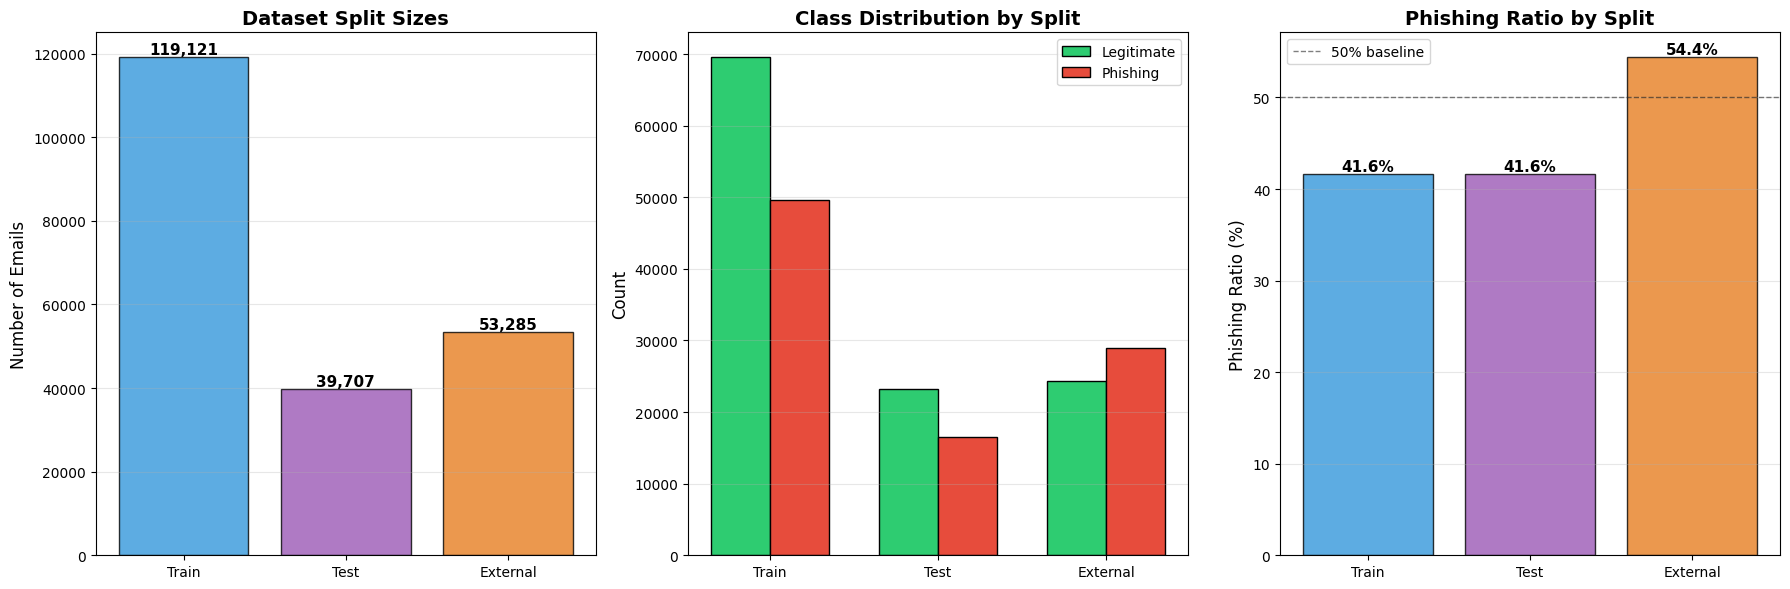

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

splits_data = {
    'Train': train_df,
    'Test': test_df,
    'External': external_df
}

ax1 = axes[0]
sizes = [len(train_df), len(test_df), len(external_df)]
colors_splits = ['#3498db', '#9b59b6', '#e67e22']
bars = ax1.bar(['Train', 'Test', 'External'], sizes, color=colors_splits, edgecolor='black', alpha=0.8)
ax1.set_ylabel('Number of Emails', fontsize=12)
ax1.set_title('Dataset Split Sizes', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2 = axes[1]
x_pos = np.arange(3)
width = 0.35
phishing_counts = [
    train_df.filter(pl.col("phishing") == 1).shape[0],
    test_df.filter(pl.col("phishing") == 1).shape[0],
    external_df.filter(pl.col("phishing") == 1).shape[0]
]
legit_counts = [
    train_df.filter(pl.col("phishing") == 0).shape[0],
    test_df.filter(pl.col("phishing") == 0).shape[0],
    external_df.filter(pl.col("phishing") == 0).shape[0]
]
ax2.bar(x_pos - width/2, legit_counts, width, label='Legitimate', color='#2ecc71', edgecolor='black')
ax2.bar(x_pos + width/2, phishing_counts, width, label='Phishing', color='#e74c3c', edgecolor='black')
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Class Distribution by Split', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(['Train', 'Test', 'External'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

ax3 = axes[2]
phishing_ratios = [
    phishing_counts[0] / sizes[0] * 100,
    phishing_counts[1] / sizes[1] * 100,
    phishing_counts[2] / sizes[2] * 100
]
bars = ax3.bar(['Train', 'Test', 'External'], phishing_ratios, color=colors_splits, edgecolor='black', alpha=0.8)
ax3.set_ylabel('Phishing Ratio (%)', fontsize=12)
ax3.set_title('Phishing Ratio by Split', fontsize=14, fontweight='bold')
ax3.axhline(y=50, color='black', linestyle='--', linewidth=1, alpha=0.5, label='50% baseline')
ax3.grid(axis='y', alpha=0.3)
ax3.legend()

for bar, ratio in zip(bars, phishing_ratios):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{ratio:.1f}%',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
wandb.log({"dataset_analysis/split_distributions": wandb.Image(fig)})
plt.show()
plt.close()

split_info_data = []
for split_name, split_df_pl in [('Train', train_df), ('Test', test_df), ('External', external_df)]:
    phish = split_df_pl.filter(pl.col("phishing") == 1).shape[0]
    total = len(split_df_pl)
    split_info_data.append([split_name, total, phish, total - phish, phish / total * 100])

wandb.log({"dataset_analysis/split_info": wandb.Table(
    columns=["split", "total", "phishing", "legitimate", "phishing_ratio_%"],
    data=split_info_data
)})


## 6. Generate Text Embeddings

In [71]:
# Load sentence transformer model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Generating embeddings on {device}...")

embedding_model = SentenceTransformer(config["embedding_model"], device=device)

# Generate embeddings for each split
print("Encoding train set...")
X_emb_train = embedding_model.encode(
    train_df['body_subject'].to_list(), 
    show_progress_bar=True, 
    convert_to_numpy=True,
    batch_size=32
)

print("Encoding test set...")
X_emb_test = embedding_model.encode(
    test_df['body_subject'].to_list(), 
    show_progress_bar=True, 
    convert_to_numpy=True,
    batch_size=32
)

print("Encoding external set...")
X_emb_external = embedding_model.encode(
    external_df['body_subject'].to_list(), 
    show_progress_bar=True, 
    convert_to_numpy=True,
    batch_size=32
)

# Extract labels
y_train = train_df['phishing'].to_numpy()
y_test = test_df['phishing'].to_numpy()
y_external = external_df['phishing'].to_numpy()

print(f"\nEmbedding shapes:")
print(f"  Train: {X_emb_train.shape}")
print(f"  Test: {X_emb_test.shape}")
print(f"  External: {X_emb_external.shape}")

wandb.log({
    "embedding_dim": X_emb_train.shape[1],
    "embedding_model": config["embedding_model"]
})

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: d84f2943-376f-41c0-8d04-8e1c8be46d05)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].


Generating embeddings on cuda...
Encoding train set...


Batches: 100%|██████████| 3723/3723 [03:49<00:00, 16.26it/s]


Encoding test set...


Batches: 100%|██████████| 1241/1241 [02:06<00:00,  9.79it/s]


Encoding external set...


Batches: 100%|██████████| 1666/1666 [01:49<00:00, 15.28it/s]



Embedding shapes:
  Train: (119121, 384)
  Test: (39707, 384)
  External: (53285, 384)


## 7. Train TF-IDF Baseline Model

Combined feature shape: (119121, 10011)
  TF-IDF features: 10000
  Engineered features: 11


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s finished



Using threshold: 0.4

TF-IDF + Logistic Regression (threshold=0.4)

Test Set Performance:
  Accuracy:  0.9538
  Precision: 0.9031
  Recall:    0.9959
  F1 Score:  0.9472
  ROC-AUC:   0.9975

External Validation:
  Accuracy:  0.9015
  Precision: 0.8689
  Recall:    0.9644
  F1 Score:  0.9141
  ROC-AUC:   0.9684

Top 20 most important features:
 1. nnews                          -16.089881
 2. 0px                            -12.967291
 3. bonuses                        -11.129989
 4. num_links                      -9.903512
 5. songs                          -8.524370
 6. titles                         -8.489877
 7. nintel                         +8.414066
 8. foundation                     -8.212980
 9. wells                          +7.942532
10. demonstration                  -7.551418
11. crust                          -7.162257
12. discovery                      +7.159186
13. re                             +7.136321
14. reservations                   -7.093409
15. fly              

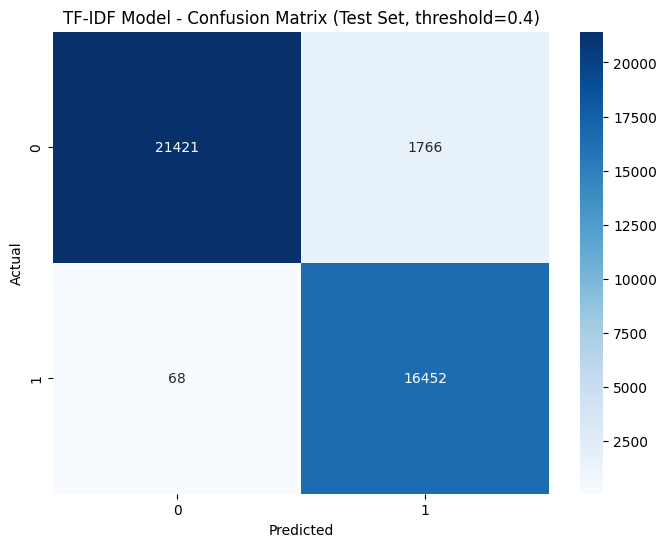

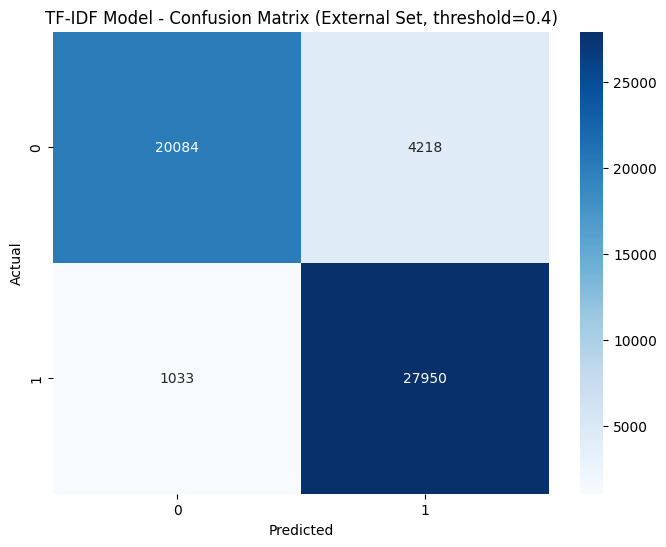

In [72]:
from scipy.sparse import hstack
tfidf = TfidfVectorizer(
    max_features=config["tfidf_max_features"],
    ngram_range=config["tfidf_ngram_range"],
    min_df=config["tfidf_min_df"],
    max_df=config["tfidf_max_df"]
)


X_tfidf_train = tfidf.fit_transform(train_df['body_subject'].to_list())
X_tfidf_test = tfidf.transform(test_df['body_subject'].to_list())
X_tfidf_external = tfidf.transform(external_df['body_subject'].to_list())

X_combined_train = hstack([X_tfidf_train, features_train])
X_combined_test = hstack([X_tfidf_test, features_test])
X_combined_external = hstack([X_tfidf_external, features_external])

print(f"Combined feature shape: {X_combined_train.shape}")
print(f"  TF-IDF features: {X_tfidf_train.shape[1]}")
print(f"  Engineered features: {features_train.shape[1]}")

class_weights = {0: 1.0, 1: config['lr_class_weight_ratio']}

lr_clf = LogisticRegression(
    max_iter=config["lr_max_iter"],
    C=config["lr_C"],
    class_weight=class_weights,
    random_state=config["random_seed"],
    verbose=1
)
lr_clf.fit(X_combined_train, y_train)

phishing_threshold = config['tfidf_threshold']
print(f"\nUsing threshold: {phishing_threshold}")

# Evaluate on test set
y_proba_test_tfidf = lr_clf.predict_proba(X_combined_test)[:, 1]
y_pred_test_tfidf = (y_proba_test_tfidf >= phishing_threshold).astype(int)

tfidf_test_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_test_tfidf),
    'precision': precision_score(y_test, y_pred_test_tfidf, zero_division=0),
    'recall': recall_score(y_test, y_pred_test_tfidf, zero_division=0),
    'f1': f1_score(y_test, y_pred_test_tfidf, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba_test_tfidf)
}

# Evaluate on external set
y_proba_ext_tfidf = lr_clf.predict_proba(X_combined_external)[:, 1]
y_pred_ext_tfidf = (y_proba_ext_tfidf >= phishing_threshold).astype(int)

tfidf_external_metrics = {
    'accuracy': accuracy_score(y_external, y_pred_ext_tfidf),
    'precision': precision_score(y_external, y_pred_ext_tfidf, zero_division=0),
    'recall': recall_score(y_external, y_pred_ext_tfidf, zero_division=0),
    'f1': f1_score(y_external, y_pred_ext_tfidf, zero_division=0),
    'roc_auc': roc_auc_score(y_external, y_proba_ext_tfidf)
}

print(f"\nTF-IDF + Logistic Regression (threshold={phishing_threshold})")
print(f"\nTest Set Performance:")
print(f"  Accuracy:  {tfidf_test_metrics['accuracy']:.4f}")
print(f"  Precision: {tfidf_test_metrics['precision']:.4f}")
print(f"  Recall:    {tfidf_test_metrics['recall']:.4f}")
print(f"  F1 Score:  {tfidf_test_metrics['f1']:.4f}")
print(f"  ROC-AUC:   {tfidf_test_metrics['roc_auc']:.4f}")

print(f"\nExternal Validation:")
print(f"  Accuracy:  {tfidf_external_metrics['accuracy']:.4f}")
print(f"  Precision: {tfidf_external_metrics['precision']:.4f}")
print(f"  Recall:    {tfidf_external_metrics['recall']:.4f}")
print(f"  F1 Score:  {tfidf_external_metrics['f1']:.4f}")
print(f"  ROC-AUC:   {tfidf_external_metrics['roc_auc']:.4f}")

feature_names = list(tfidf.vocabulary_.keys()) + numeric_features
coefficients = lr_clf.coef_[0]
feature_importance = sorted(zip(feature_names, coefficients), key=lambda x: abs(x[1]), reverse=True)

print(f"\nTop 20 most important features:")
for i, (name, coef) in enumerate(feature_importance[:20], 1):
    print(f"{i:2d}. {name:<30s} {coef:+.6f}")

# Log to WandB
wandb.log({
    "tfidf/phishing_threshold": phishing_threshold,
    "tfidf/class_weight_ratio": config['lr_class_weight_ratio'],
    "tfidf/test_accuracy": tfidf_test_metrics['accuracy'],
    "tfidf/test_precision": tfidf_test_metrics['precision'],
    "tfidf/test_recall": tfidf_test_metrics['recall'],
    "tfidf/test_f1": tfidf_test_metrics['f1'],
    "tfidf/test_roc_auc": tfidf_test_metrics['roc_auc'],
    "tfidf/external_accuracy": tfidf_external_metrics['accuracy'],
    "tfidf/external_precision": tfidf_external_metrics['precision'],
    "tfidf/external_recall": tfidf_external_metrics['recall'],
    "tfidf/external_f1": tfidf_external_metrics['f1'],
    "tfidf/external_roc_auc": tfidf_external_metrics['roc_auc'],
})

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test_tfidf)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'TF-IDF Model - Confusion Matrix (Test Set, threshold={phishing_threshold})')
plt.show()
wandb.log({"tfidf/confusion_matrix": wandb.Image(fig)})
plt.close()

cm = confusion_matrix(y_external, y_pred_ext_tfidf)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'TF-IDF Model - Confusion Matrix (External Set, threshold={phishing_threshold})')
plt.show()
wandb.log({"tfidf/confusion_matrix": wandb.Image(fig)})
plt.close()

## 8. Train Hybrid XGBoost Model

Combined feature shape: (119121, 395)
  Full embeddings: 384
  Engineered features: 11

Training XGBoost...
[0]	validation_0-logloss:1.00122	validation_0-auc:0.90524	validation_1-logloss:1.00184	validation_1-auc:0.89566
[10]	validation_0-logloss:0.80889	validation_0-auc:0.97329	validation_1-logloss:0.81404	validation_1-auc:0.96446
[20]	validation_0-logloss:0.68283	validation_0-auc:0.98161	validation_1-logloss:0.69174	validation_1-auc:0.97350
[30]	validation_0-logloss:0.58955	validation_0-auc:0.98620	validation_1-logloss:0.60187	validation_1-auc:0.97838
[40]	validation_0-logloss:0.51887	validation_0-auc:0.98781	validation_1-logloss:0.53438	validation_1-auc:0.98010
[50]	validation_0-logloss:0.46290	validation_0-auc:0.98969	validation_1-logloss:0.48114	validation_1-auc:0.98219
[60]	validation_0-logloss:0.41635	validation_0-auc:0.99117	validation_1-logloss:0.43684	validation_1-auc:0.98390
[70]	validation_0-logloss:0.37686	validation_0-auc:0.99249	validation_1-logloss:0.39931	validation_1-a

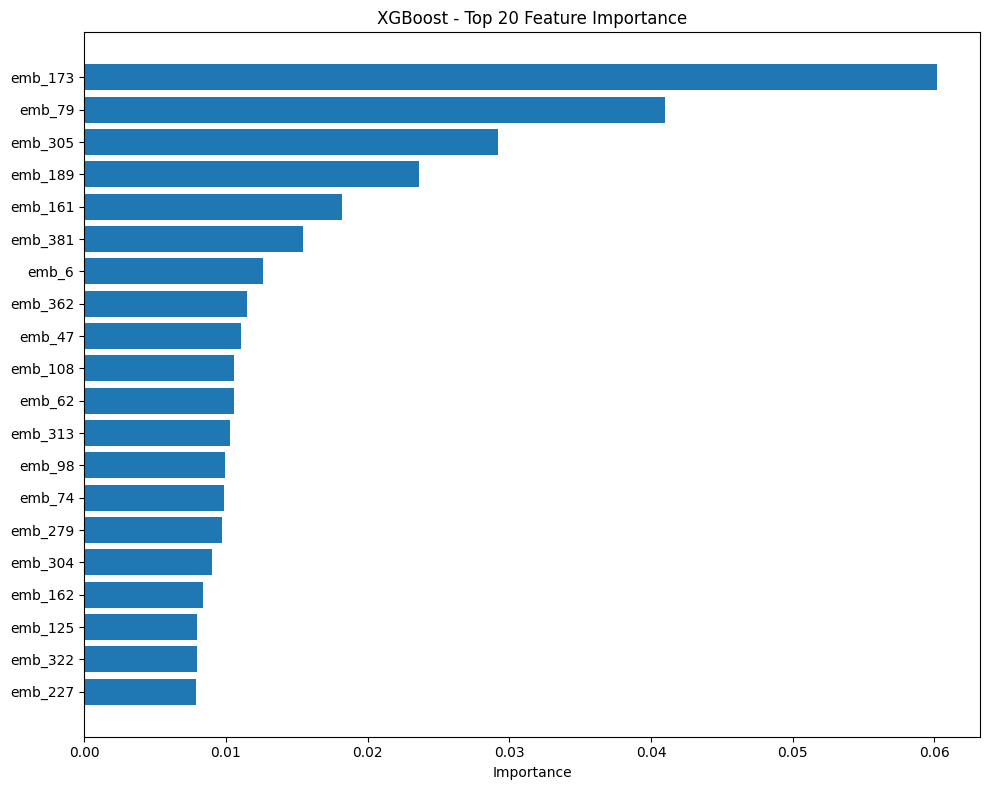

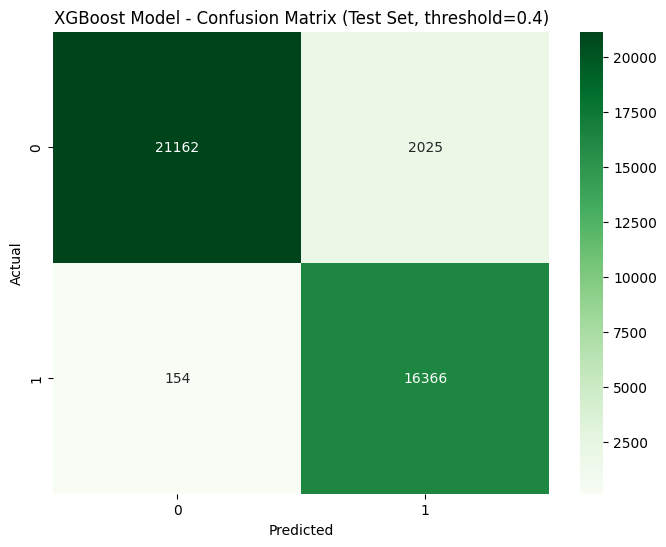

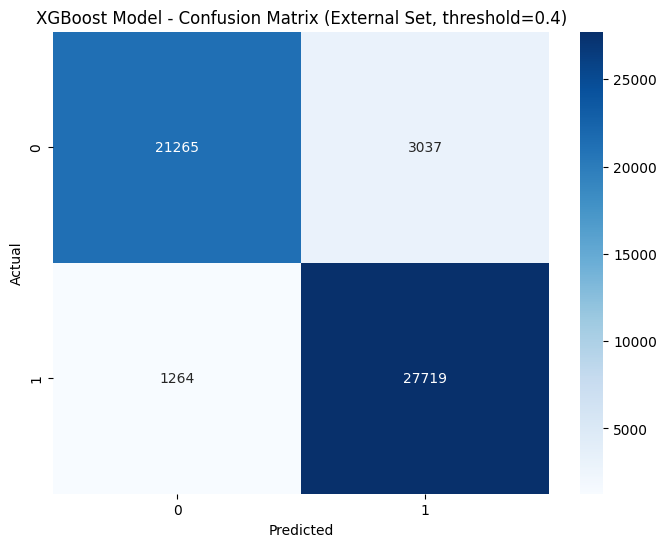

In [73]:
X_xgb_train = np.concatenate([X_emb_train, features_train], axis=1)
X_xgb_test = np.concatenate([X_emb_test, features_test], axis=1)
X_xgb_external = np.concatenate([X_emb_external, features_external], axis=1)

print(f"Combined feature shape: {X_xgb_train.shape}")
print(f"  Full embeddings: {X_emb_train.shape[1]}")
print(f"  Engineered features: {features_train.shape[1]}")

scale_pos_weight = config['xgb_scale_pos_weight']

# Train XGBoost with WandB callback
xgb_clf = xgb.XGBClassifier(
    max_depth=config["xgb_max_depth"],
    n_estimators=config["xgb_n_estimators"],
    learning_rate=config["xgb_learning_rate"],
    min_child_weight=config["xgb_min_child_weight"],
    subsample=config["xgb_subsample"],
    colsample_bytree=config["xgb_colsample_bytree"],
    scale_pos_weight=scale_pos_weight,
    random_state=config["random_seed"],
    eval_metric=["logloss", "auc"],
    early_stopping_rounds=config["xgb_early_stopping"],
    callbacks=[wandb.xgboost.WandbCallback(log_model=True)]
)

print("\nTraining XGBoost...")
xgb_clf.fit(
    X_xgb_train, y_train,
    eval_set=[(X_xgb_train, y_train), (X_xgb_test, y_test)],
    verbose=10
)

phishing_threshold = config['xgb_threshold']
print(f"\nUsing threshold: {phishing_threshold}")

# Evaluate on test set
y_proba_test_xgb = xgb_clf.predict_proba(X_xgb_test)[:, 1]
y_pred_test_xgb = (y_proba_test_xgb >= phishing_threshold).astype(int)

xgb_test_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_test_xgb),
    'precision': precision_score(y_test, y_pred_test_xgb, zero_division=0),
    'recall': recall_score(y_test, y_pred_test_xgb, zero_division=0),
    'f1': f1_score(y_test, y_pred_test_xgb, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba_test_xgb)
}

# Evaluate on external set
y_proba_ext_xgb = xgb_clf.predict_proba(X_xgb_external)[:, 1]
y_pred_ext_xgb = (y_proba_ext_xgb >= phishing_threshold).astype(int)

xgb_external_metrics = {
    'accuracy': accuracy_score(y_external, y_pred_ext_xgb),
    'precision': precision_score(y_external, y_pred_ext_xgb, zero_division=0),
    'recall': recall_score(y_external, y_pred_ext_xgb, zero_division=0),
    'f1': f1_score(y_external, y_pred_ext_xgb, zero_division=0),
    'roc_auc': roc_auc_score(y_external, y_proba_ext_xgb)
}

print(f"\n XGBoost Hybrid Model (threshold={phishing_threshold})")
print(f"\nTest Set Performance:")
print(f"  Accuracy:  {xgb_test_metrics['accuracy']:.4f}")
print(f"  Precision: {xgb_test_metrics['precision']:.4f}")
print(f"  Recall:    {xgb_test_metrics['recall']:.4f}")
print(f"  F1 Score:  {xgb_test_metrics['f1']:.4f}")
print(f"  ROC-AUC:   {xgb_test_metrics['roc_auc']:.4f}")

print(f"\nExternal Validation:")
print(f"  Accuracy:  {xgb_external_metrics['accuracy']:.4f}")
print(f"  Precision: {xgb_external_metrics['precision']:.4f}")
print(f"  Recall:    {xgb_external_metrics['recall']:.4f}")
print(f"  F1 Score:  {xgb_external_metrics['f1']:.4f}")
print(f"  ROC-AUC:   {xgb_external_metrics['roc_auc']:.4f}")

# Log to WandB
wandb.log({
    "xgboost/phishing_threshold": phishing_threshold,
    "xgboost/scale_pos_weight": scale_pos_weight,
    "xgboost/test_accuracy": xgb_test_metrics['accuracy'],
    "xgboost/test_precision": xgb_test_metrics['precision'],
    "xgboost/test_recall": xgb_test_metrics['recall'],
    "xgboost/test_f1": xgb_test_metrics['f1'],
    "xgboost/test_roc_auc": xgb_test_metrics['roc_auc'],
    "xgboost/external_accuracy": xgb_external_metrics['accuracy'],
    "xgboost/external_precision": xgb_external_metrics['precision'],
    "xgboost/external_recall": xgb_external_metrics['recall'],
    "xgboost/external_f1": xgb_external_metrics['f1'],
    "xgboost/external_roc_auc": xgb_external_metrics['roc_auc'],
})

feature_names = [f"emb_{i}" for i in range(X_emb_train.shape[1])] + numeric_features
importance = xgb_clf.feature_importances_
feature_importance = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)

print(f"\nTop 20 most important features:")
for i, (name, imp) in enumerate(feature_importance[:20], 1):
    print(f"{i:2d}. {name:<30s} {imp:.6f}")

fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance[:20]
ax.barh([f[0] for f in top_features][::-1], [f[1] for f in top_features][::-1])
ax.set_xlabel('Importance')
ax.set_title('XGBoost - Top 20 Feature Importance')
plt.tight_layout()
wandb.log({"xgboost/feature_importance": wandb.Image(fig)})
plt.show()
plt.close()

# Confusion matrix for XGBoost
cm = confusion_matrix(y_test, y_pred_test_xgb)
fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax_cm)
ax_cm.set_xlabel('Predicted')
ax_cm.set_ylabel('Actual')
ax_cm.set_title(f'XGBoost Model - Confusion Matrix (Test Set, threshold={phishing_threshold})')
wandb.log({"xgboost/confusion_matrix": wandb.Image(fig_cm)})
plt.show()
plt.close()

cm = confusion_matrix(y_external, y_pred_ext_xgb)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'XGBoost Model - Confusion Matrix (External Set, threshold={phishing_threshold})')
plt.show()
wandb.log({"xgboost/confusion_matrix": wandb.Image(fig)})
plt.close()


## 9. Train Hybrid MLP Model

In [ ]:
from hybrid_mlp_model import HybridMLPClassifier

X_emb_train_fit, X_emb_val, X_feat_train_fit, X_feat_val, y_train_fit, y_val = train_test_split(
    X_emb_train, features_train, y_train, 
    test_size=0.2, 
    random_state=config["random_seed"], 
    stratify=y_train
)

print(f"Train: {X_emb_train_fit.shape[0]} | Val: {X_emb_val.shape[0]} | Test: {X_emb_test.shape[0]}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_model = HybridMLPClassifier(
    embedding_dim=config["embedding_dim"],
    num_features=len(numeric_features),
    feature_hidden_dim=config["mlp_feature_hidden_dim"],
    dropout=config["mlp_dropout"]
).to(device)

print(mlp_model)
print(f"\nTotal parameters: {sum(p.numel() for p in mlp_model.parameters()):,}")

# Create data loaders
train_dataset = TensorDataset(
    torch.FloatTensor(X_emb_train_fit),
    torch.FloatTensor(X_feat_train_fit),
    torch.FloatTensor(y_train_fit)
)
val_dataset = TensorDataset(
    torch.FloatTensor(X_emb_val),
    torch.FloatTensor(X_feat_val),
    torch.FloatTensor(y_val)
)
test_dataset = TensorDataset(
    torch.FloatTensor(X_emb_test),
    torch.FloatTensor(features_test),
    torch.FloatTensor(y_test)
)

train_loader = DataLoader(train_dataset, batch_size=config["mlp_batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config["mlp_batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config["mlp_batch_size"], shuffle=False)

# Training setup
optimizer = torch.optim.Adam(
    mlp_model.parameters(), 
    lr=config["mlp_lr"], 
    weight_decay=config["mlp_weight_decay"]
)

pos_weight = torch.tensor([config['mlp_pos_weight']], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Training loop
best_val_loss = float('inf')
patience_counter = 0

print("\nTraining MLP...")
for epoch in range(config["mlp_epochs"]):
    # Training
    mlp_model.train()
    train_loss = 0
    for embeddings, features, labels in train_loader:
        embeddings, features, labels = embeddings.to(device), features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logits = mlp_model(embeddings, features).squeeze()
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Validation
    mlp_model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for embeddings, features, labels in val_loader:
            embeddings, features, labels = embeddings.to(device), features.to(device), labels.to(device)
            
            logits = mlp_model(embeddings, features).squeeze()
            loss = criterion(logits, labels)
            val_loss += loss.item()
            
            probs = torch.sigmoid(logits)
            val_preds.extend(probs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    val_loss /= len(val_loader)
    val_preds = np.array(val_preds)
    val_labels = np.array(val_labels)
    val_pred_binary = (val_preds > 0.5).astype(int)
    
    val_acc = accuracy_score(val_labels, val_pred_binary)
    val_f1 = f1_score(val_labels, val_pred_binary, zero_division=0)
    
    # Log to WandB
    wandb.log({
        "mlp/epoch": epoch,
        "mlp/train_loss": train_loss,
        "mlp/val_loss": val_loss,
        "mlp/val_accuracy": val_acc,
        "mlp/val_f1": val_f1
    })
    
    print(f"Epoch {epoch+1}/{config['mlp_epochs']}: "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        best_model_state = mlp_model.state_dict().copy()
    else:
        patience_counter += 1
        if patience_counter >= config["mlp_early_stopping"]:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load best model
mlp_model.load_state_dict(best_model_state)

Train: 95296 | Val: 23825 | Test: 39707
HybridMLPClassifier(
  (feature_branch): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=448, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

Total parameters: 148,737

Training MLP...
Epoch 1/50: Train Loss: 0.4301 | Val Loss: 0.2495 | Val Acc: 0.9421 | Val F1: 0.9343
Epoch 2/50: Train Loss: 0.2583 | Val Loss: 0.2105 | Val Acc: 0.9478 | Val F1: 0.9406
Epoch 3/50: Train Loss: 0.2266 | Val Loss: 0.1965 | Val Acc: 0.9579 | Val F1: 0.9515
Epoch 4/50: Train Loss: 0.2036 | Val Loss: 0.2050 | Val Acc: 0.9550 | Val F1: 0.9483
Epoch 5/50: Train Loss: 0.1962 | Val Loss: 0.1841 | Val Acc: 0.9566 | Val F1

<All keys matched successfully>


Using threshold: 0.4

MLP Hybrid Model (threshold=0.4)

Test Set Performance:
  Accuracy:  0.9558
  Precision: 0.9082
  Recall:    0.9942
  F1 Score:  0.9492
  ROC-AUC:   0.9973

External Validation:
  Accuracy:  0.9180
  Precision: 0.8955
  Recall:    0.9614
  F1 Score:  0.9273
  ROC-AUC:   0.9767


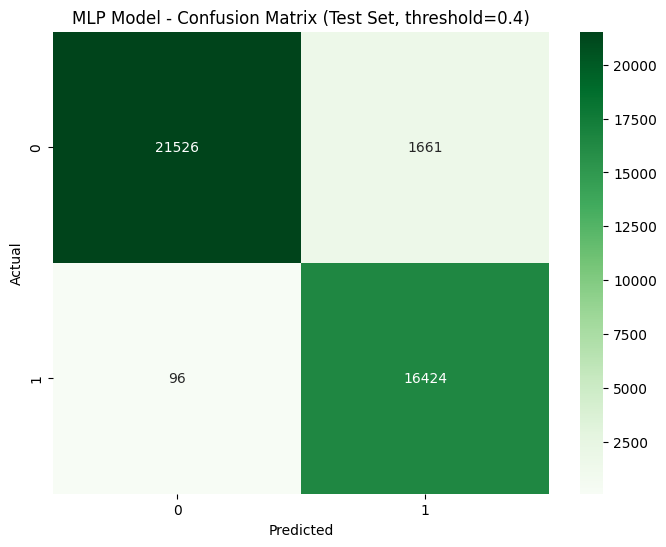

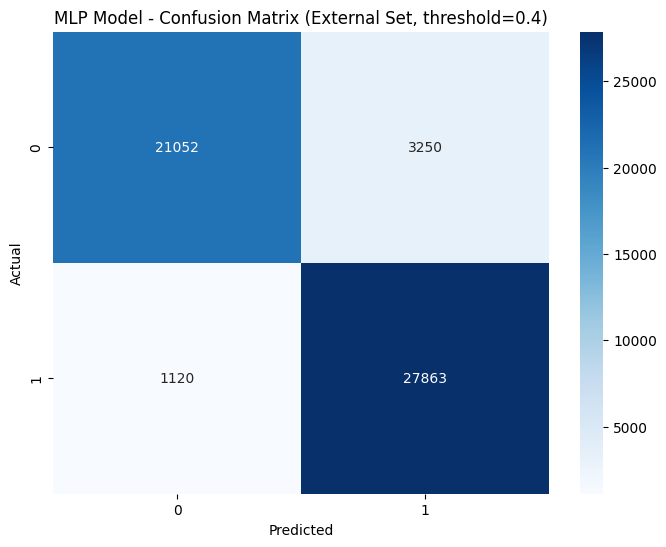

In [75]:
phishing_threshold = config['mlp_threshold']
print(f"\nUsing threshold: {phishing_threshold}")

# Evaluate MLP on test set
mlp_model.eval()
test_preds = []
test_labels = []
test_probs = []

with torch.no_grad():
    for embeddings, features, labels in test_loader:
        embeddings, features = embeddings.to(device), features.to(device)
        
        logits = mlp_model(embeddings, features).squeeze()
        probs = torch.sigmoid(logits)
        
        # Handle both batch and single samples
        if probs.dim() == 0:
            test_probs.append(probs.cpu().item())
            test_labels.append(labels.item())
        else:
            test_probs.extend(probs.cpu().numpy())
            test_labels.extend(labels.numpy())

test_probs = np.array(test_probs)
test_labels = np.array(test_labels)
test_preds = (test_probs >= phishing_threshold).astype(int)

mlp_test_metrics = {
    'accuracy': accuracy_score(test_labels, test_preds),
    'precision': precision_score(test_labels, test_preds, zero_division=0),
    'recall': recall_score(test_labels, test_preds, zero_division=0),
    'f1': f1_score(test_labels, test_preds, zero_division=0),
    'roc_auc': roc_auc_score(test_labels, test_probs)
}

# Evaluate on external set
external_dataset = TensorDataset(
    torch.FloatTensor(X_emb_external),
    torch.FloatTensor(features_external),
    torch.FloatTensor(y_external)
)
external_loader = DataLoader(external_dataset, batch_size=config["mlp_batch_size"], shuffle=False)

ext_preds = []
ext_labels = []
ext_probs = []

with torch.no_grad():
    for embeddings, features, labels in external_loader:
        embeddings, features = embeddings.to(device), features.to(device)
        
        logits = mlp_model(embeddings, features).squeeze()
        probs = torch.sigmoid(logits)
        
        # Handle both batch and single samples
        if probs.dim() == 0:
            ext_probs.append(probs.cpu().item())
            ext_labels.append(labels.item())
        else:
            ext_probs.extend(probs.cpu().numpy())
            ext_labels.extend(labels.numpy())

ext_probs = np.array(ext_probs)
ext_labels = np.array(ext_labels)
ext_preds = (ext_probs >= phishing_threshold).astype(int)

mlp_external_metrics = {
    'accuracy': accuracy_score(ext_labels, ext_preds),
    'precision': precision_score(ext_labels, ext_preds, zero_division=0),
    'recall': recall_score(ext_labels, ext_preds, zero_division=0),
    'f1': f1_score(ext_labels, ext_preds, zero_division=0),
    'roc_auc': roc_auc_score(ext_labels, ext_probs)
}

print(f"\nMLP Hybrid Model (threshold={phishing_threshold})")
print(f"\nTest Set Performance:")
print(f"  Accuracy:  {mlp_test_metrics['accuracy']:.4f}")
print(f"  Precision: {mlp_test_metrics['precision']:.4f}")
print(f"  Recall:    {mlp_test_metrics['recall']:.4f}")
print(f"  F1 Score:  {mlp_test_metrics['f1']:.4f}")
print(f"  ROC-AUC:   {mlp_test_metrics['roc_auc']:.4f}")

print(f"\nExternal Validation:")
print(f"  Accuracy:  {mlp_external_metrics['accuracy']:.4f}")
print(f"  Precision: {mlp_external_metrics['precision']:.4f}")
print(f"  Recall:    {mlp_external_metrics['recall']:.4f}")
print(f"  F1 Score:  {mlp_external_metrics['f1']:.4f}")
print(f"  ROC-AUC:   {mlp_external_metrics['roc_auc']:.4f}")

wandb.log({
    "mlp/phishing_threshold": phishing_threshold,
    "mlp/pos_weight": config['mlp_pos_weight'],
    "mlp/test_accuracy": mlp_test_metrics['accuracy'],
    "mlp/test_precision": mlp_test_metrics['precision'],
    "mlp/test_recall": mlp_test_metrics['recall'],
    "mlp/test_f1": mlp_test_metrics['f1'],
    "mlp/test_roc_auc": mlp_test_metrics['roc_auc'],
    "mlp/external_accuracy": mlp_external_metrics['accuracy'],
    "mlp/external_precision": mlp_external_metrics['precision'],
    "mlp/external_recall": mlp_external_metrics['recall'],
    "mlp/external_f1": mlp_external_metrics['f1'],
    "mlp/external_roc_auc": mlp_external_metrics['roc_auc'],
})

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'MLP Model - Confusion Matrix (Test Set, threshold={phishing_threshold})')
wandb.log({"mlp/confusion_matrix": wandb.Image(fig)})
plt.show()

cm = confusion_matrix(ext_labels, ext_preds)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'MLP Model - Confusion Matrix (External Set, threshold={phishing_threshold})')
wandb.log({"mlp/confusion_matrix": wandb.Image(fig)})
plt.show()
plt.close()

## 10. Compare Model Performance

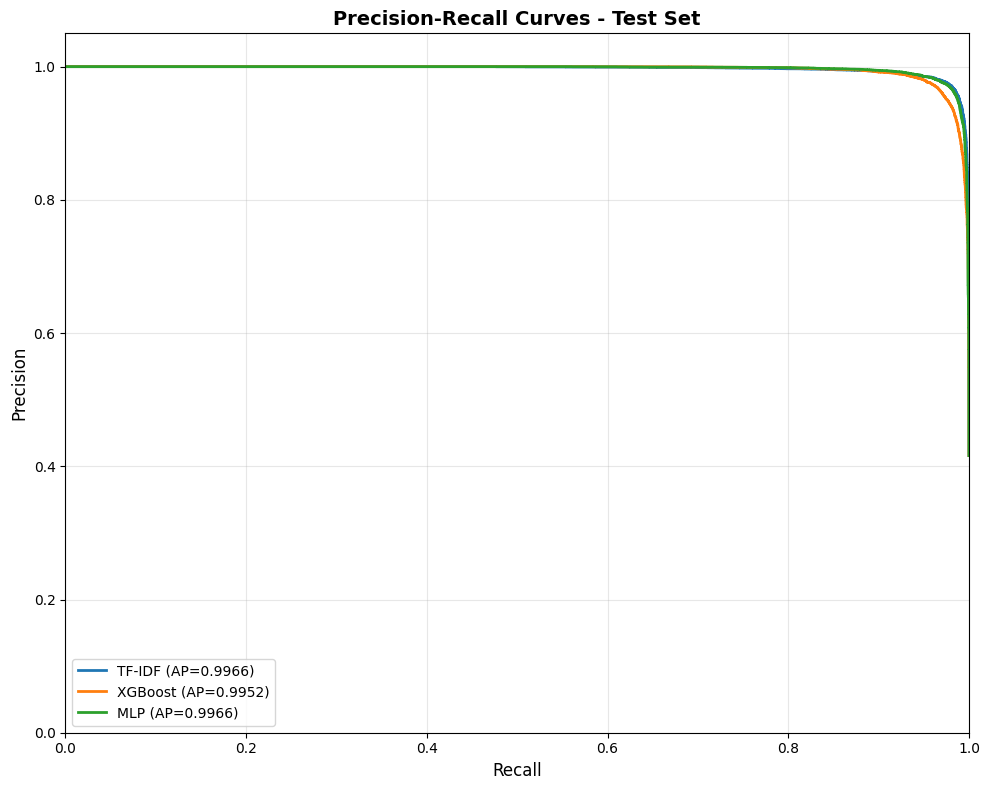

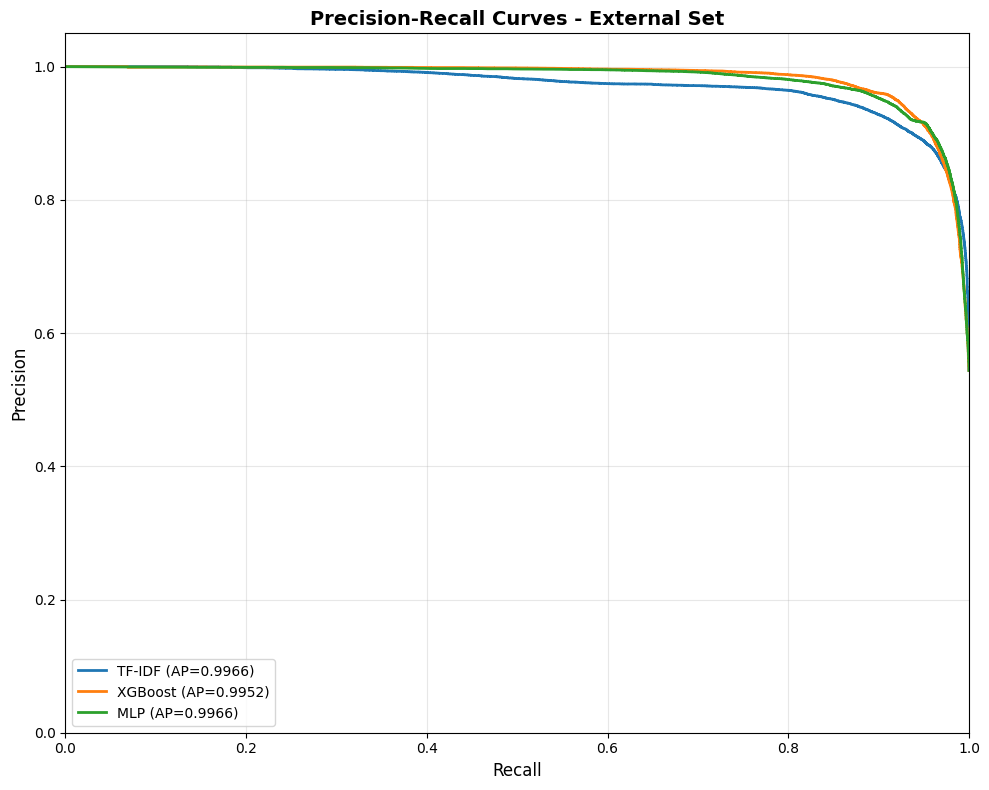


TEST SET PERFORMANCE:
Model                Accuracy     Precision    Recall       F1           ROC-AUC     
--------------------------------------------------------------------------------
TF-IDF + LogReg      0.9538       0.9031       0.9959       0.9472       0.9975      
XGBoost Hybrid       0.9451       0.8899       0.9907       0.9376       0.9962      
MLP Hybrid           0.9558       0.9082       0.9942       0.9492       0.9973      

EXTERNAL VALIDATION SET PERFORMANCE:
Model                Accuracy     Precision    Recall       F1           ROC-AUC     
--------------------------------------------------------------------------------
TF-IDF + LogReg      0.9015       0.8689       0.9644       0.9141       0.9684      
XGBoost Hybrid       0.9193       0.9013       0.9564       0.9280       0.9779      
MLP Hybrid           0.9180       0.8955       0.9614       0.9273       0.9767      


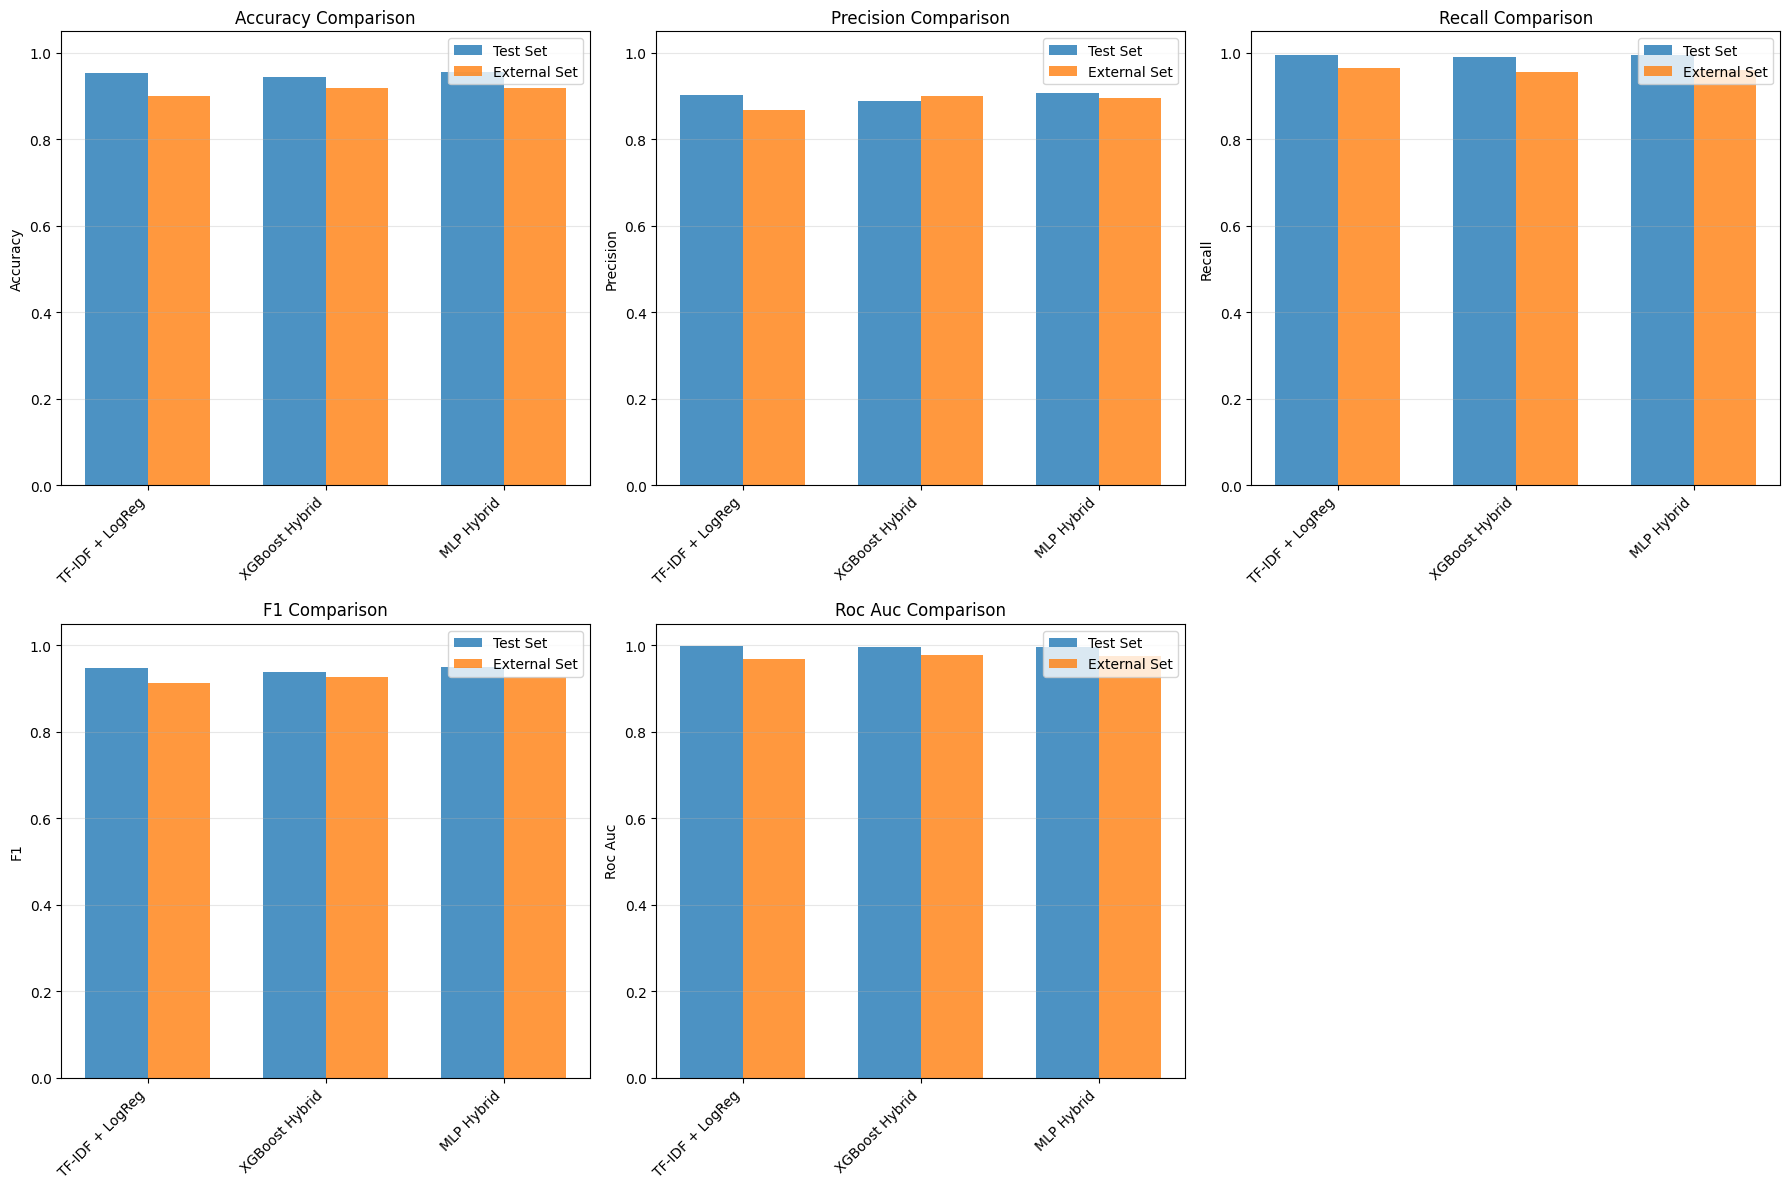

In [76]:
# Create comprehensive comparison
comparison_data = {
    'TF-IDF + LogReg': {
        'test': tfidf_test_metrics,
        'external': tfidf_external_metrics
    },
    'XGBoost Hybrid': {
        'test': xgb_test_metrics,
        'external': xgb_external_metrics
    },
    'MLP Hybrid': {
        'test': mlp_test_metrics,
        'external': mlp_external_metrics
    }
}

from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate PR curves
tfidf_precision_test, tfidf_recall_test, _ = precision_recall_curve(y_test, y_proba_test_tfidf)
xgb_precision_test, xgb_recall_test, _ = precision_recall_curve(y_test, y_proba_test_xgb)
mlp_precision_test, mlp_recall_test, _ = precision_recall_curve(test_labels, test_probs)

tfidf_precision_ex, tfidf_recall_ex, _ = precision_recall_curve(y_external, y_proba_ext_tfidf)
xgb_precision_ex, xgb_recall_ex, _ = precision_recall_curve(y_external, y_proba_ext_xgb)
mlp_precision_ex, mlp_recall_ex, _ = precision_recall_curve(ext_labels, ext_probs)


# Calculate average precision
tfidf_ap = average_precision_score(y_test, y_proba_test_tfidf)
xgb_ap = average_precision_score(y_test, y_proba_test_xgb)
mlp_ap = average_precision_score(test_labels, test_probs)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(tfidf_recall_test, tfidf_precision_test, label=f'TF-IDF (AP={tfidf_ap:.4f})', linewidth=2)
ax.plot(xgb_recall_test, xgb_precision_test, label=f'XGBoost (AP={xgb_ap:.4f})', linewidth=2)
ax.plot(mlp_recall_test, mlp_precision_test, label=f'MLP (AP={mlp_ap:.4f})', linewidth=2)
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves - Test Set', fontsize=14, fontweight='bold')
ax.legend(loc='lower left', fontsize=10)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])

plt.tight_layout()
wandb.log({"comparison/pr_curves": wandb.Image(fig)})
plt.show()
plt.close()

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(tfidf_recall_ex, tfidf_precision_ex, label=f'TF-IDF (AP={tfidf_ap:.4f})', linewidth=2)
ax.plot(xgb_recall_ex, xgb_precision_ex, label=f'XGBoost (AP={xgb_ap:.4f})', linewidth=2)
ax.plot(mlp_recall_ex, mlp_precision_ex, label=f'MLP (AP={mlp_ap:.4f})', linewidth=2)
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves - External Set', fontsize=14, fontweight='bold')
ax.legend(loc='lower left', fontsize=10)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])

plt.tight_layout()
wandb.log({"comparison/pr_curves": wandb.Image(fig)})
plt.show()
plt.close()

# Test set comparison
print("\nTEST SET PERFORMANCE:")
print(f"{'Model':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'ROC-AUC':<12}")
print("-" * 80)
for model_name, metrics in comparison_data.items():
    test_m = metrics['test']
    print(f"{model_name:<20} {test_m['accuracy']:<12.4f} {test_m['precision']:<12.4f} "
          f"{test_m['recall']:<12.4f} {test_m['f1']:<12.4f} {test_m['roc_auc']:<12.4f}")

# External set comparison
print("\nEXTERNAL VALIDATION SET PERFORMANCE:")
print(f"{'Model':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'ROC-AUC':<12}")
print("-" * 80)
for model_name, metrics in comparison_data.items():
    ext_m = metrics['external']
    print(f"{model_name:<20} {ext_m['accuracy']:<12.4f} {ext_m['precision']:<12.4f} "
          f"{ext_m['recall']:<12.4f} {ext_m['f1']:<12.4f} {ext_m['roc_auc']:<12.4f}")

# Create comparison visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    models = list(comparison_data.keys())
    test_values = [comparison_data[m]['test'][metric] for m in models]
    external_values = [comparison_data[m]['external'][metric] for m in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    ax.bar(x - width/2, test_values, width, label='Test Set', alpha=0.8)
    ax.bar(x + width/2, external_values, width, label='External Set', alpha=0.8)
    
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'{metric.replace("_", " ").title()} Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[1, 2])

plt.tight_layout()
wandb.log({"comparison/metrics_comparison": wandb.Image(fig)})
plt.show()

comparison_table_data = []
for model_name, metrics in comparison_data.items():
    for split, split_metrics in metrics.items():
        row = [model_name, split] + [split_metrics[m] for m in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']]
        comparison_table_data.append(row)

comparison_table = wandb.Table(
    columns=['Model', 'Split', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC'],
    data=comparison_table_data
)
wandb.log({"comparison/performance_table": comparison_table})


## 11. Save Models and Artifacts


In [77]:
# Create directories
os.makedirs("../../output/saved_models", exist_ok=True)
os.makedirs("../../output/saved_artifacts", exist_ok=True)

print("Saving models and artifacts...")

with open('../../output/saved_models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
with open('../../output/saved_models/tfidf_classifier.pkl', 'wb') as f:
    pickle.dump(lr_clf, f)

xgb_clf.save_model('../../output/saved_models/xgboost_hybrid.json')

torch.save({
    'model_state_dict': mlp_model.state_dict(),
    'embedding_dim': config["embedding_dim"],
    'num_features': len(numeric_features),
    'feature_hidden_dim': config["mlp_feature_hidden_dim"],
    'dropout': config["mlp_dropout"],
    'test_metrics': mlp_test_metrics,
    'external_metrics': mlp_external_metrics,
    'phishing_threshold': config['mlp_threshold'],
    'pos_weight': config['mlp_pos_weight']
}, '../../output/saved_models/mlp_hybrid.pth')

# Save experiment configuration
full_config = {
    'experiment_config': config,
    'optuna_optimized': {
        'objective': ' Recall + OC-AUC',
        'description': 'Hyperparameters optimized using Optuna for maximum recall and ranking ability'
    },
    'data_splits': {
        'train_size': len(train_df),
        'test_size': len(test_df),
        'external_size': len(external_df)
    },
    'model_performance': {
        'tfidf': {
            'test': {k: float(v) for k, v in tfidf_test_metrics.items()},
            'external': {k: float(v) for k, v in tfidf_external_metrics.items()}
        },
        'xgboost': {
            'test': {k: float(v) for k, v in xgb_test_metrics.items()},
            'external': {k: float(v) for k, v in xgb_external_metrics.items()}
        },
        'mlp': {
            'test': {k: float(v) for k, v in mlp_test_metrics.items()},
            'external': {k: float(v) for k, v in mlp_external_metrics.items()}
        }
    },
    'feature_names': numeric_features,
    'timestamp': datetime.now().isoformat()
}

with open('../../output/saved_artifacts/experiment_config.json', 'w') as f:
    json.dump(full_config, f, indent=2)


# Upload artifacts to WandB
artifact = wandb.Artifact('phishstop-models-recall-optimized', type='model')
artifact.add_dir('../../output/saved_models')
artifact.add_file('../../output/saved_artifacts/experiment_config.json')
wandb.log_artifact(artifact)


wandb: Adding directory to artifact (..\..\output\saved_models)... 

Saving models and artifacts...


Done. 0.1s


<Artifact phishstop-models-recall-optimized>

In [78]:
# Finish WandB run
wandb.finish()
print("✓ WandB run completed")

best_iteration,▁
best_score,▁
class_balance,▁
embedding_dim,▁
epoch,▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▇▇▇▇▇▇▇▇█
external_phishing_ratio,▁
external_size,▁
legit_count,▁
mlp/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
mlp/external_accuracy,▁
+49,...


✓ WandB run completed
